In [20]:
import os, copy
import numpy as NP
import numpy.linalg as LA
import scipy.optimize as OPT
import astropy.constants as FCNST
from astropy import units as U
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.modeling import models, fitting
import matplotlib as MPL
import matplotlib.pyplot as PLT
from matplotlib.patches import Arc, RegularPolygon
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, InsetPosition
from astroutils import geometry as GEOM
try:
    from pyuvdata import UVData
except ImportError:
    pyuvdata_found = False
else:
    pyuvdata_found = True

from IPython.core.debugger import set_trace
%matplotlib notebook

os.environ["PATH"] += os.pathsep + '/opt/local/bin/'

MPL.rcParams['xtick.direction'] = 'in'
MPL.rcParams['ytick.direction'] = 'in'

MPL.rc('text', usetex=True)
MPL.rc('text.latex',unicode=True)
MPL.rc('font', **{'size': 12,'family': 'serif', 'serif': ['Computer Modern']})

# Define some useful functions

In [2]:
def gaussian2D_without_offset((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta):
    xo = float(xo)
    yo = float(yo)    
    a = (NP.cos(theta)**2)/(2*sigma_x**2) + (NP.sin(theta)**2)/(2*sigma_y**2)
    b = -(NP.sin(2*theta))/(4*sigma_x**2) + (NP.sin(2*theta))/(4*sigma_y**2)
    c = (NP.sin(theta)**2)/(2*sigma_x**2) + (NP.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*NP.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def gaussian2D_with_offset((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = (NP.cos(theta)**2)/(2*sigma_x**2) + (NP.sin(theta)**2)/(2*sigma_y**2)
    b = -(NP.sin(2*theta))/(4*sigma_x**2) + (NP.sin(2*theta))/(4*sigma_y**2)
    c = (NP.sin(theta)**2)/(2*sigma_x**2) + (NP.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*NP.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

## Perform some IERS related adjustments

In [3]:
from astropy.utils import iers

default_iers_auto_url = 'http://maia.usno.navy.mil/ser7/finals2000A.all'
secondary_iers_auto_url = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'

try:    
#     iers.conf.iers_auto_url = default_iers_auto_url
    iers.conf.remote_timeout = 100.0
    iers.IERS_A.open(iers.IERS_A_URL)
except Exception as err:
    if ('url' in str(err).lower()) or (('connection' in str(err).lower())):
        print(err)
        print('Original source URL for IERS_A: {0} failed!'.format(iers.conf.iers_auto_url))
        print('Original IERS Configuration:')
        print(iers.conf.__class__.__dict__)
        print('Modifying the source URL for IERS_A table to {0}'.format(secondary_iers_auto_url))
#         iers.IERS_A_URL = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'
        iers.conf.auto_download = True
        iers.conf.iers_auto_url = secondary_iers_auto_url
#         iers.conf.iers_auto_url = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'
        try:
            print('Now testing {0}'.format(secondary_iers_auto_url))
            iers_a = iers.IERS_A.open(secondary_iers_auto_url)
        except Exception as newerr:
            if ('url' in str(err).lower()):
                print(newerr)
                print('Modified URL also did not work. Computation of LST may be affected or will completely fail.')
#                 raise newerr
        else:
            print('Updated source URL {0} worked!'.format(secondary_iers_auto_url))
            print('Modified IERS Configuration:')
            print(iers.conf.__class__.__dict__)

<urlopen error [Errno -2] Name or service not known>
Original source URL for IERS_A: http://maia.usno.navy.mil/ser7/finals2000A.all failed!
Original IERS Configuration:
{'__module__': 'astropy.utils.iers.iers', 'auto_download': <ConfigItem: name='auto_download' value=True at 0x7f39892f7d50>, 'iers_auto_url': <ConfigItem: name='iers_auto_url' value=u'http://maia.usno.navy.mil/ser7/finals2000A.all' at 0x7f39897ea890>, 'remote_timeout': <ConfigItem: name='remote_timeout' value=10.0 at 0x7f3988a68790>, 'auto_max_age': <ConfigItem: name='auto_max_age' value=30.0 at 0x7f39897ea8d0>, '__doc__': u'\n    Configuration parameters for `astropy.utils.iers`.\n    '}
Modifying the source URL for IERS_A table to ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all
Now testing ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all
<urlopen error timed out>
Modified URL also did not work. Computation of LST may be affected or will completely fail.


# Set up folders

In [4]:
projectdir = '/lustre/aoc/users/nthyagar/projects/CPhaseGeom/'
datadir = projectdir + 'data/'
figdir = projectdir + 'figures/'

# Work on 3C286 FITS image

In [5]:
# datadir_3c286 = datadir + '3C286/image/4min/'
datadir_3c286 = datadir + '3C286/image/20sec/'

## Read image information

In [12]:
imgfilenames_orig = {'bl-fringes': {'cal': ['0913.fits', '0919.fits', '1319.fits'], 'uncal': ['0913u.fits', '0919u.fits', '1319u.fits']}, 'triad-fringes': {'cal': '3fringecal.fits', 'uncal': '3fringeuncal.fits'}}
imgfilenames_new = {'bl-fringes': {'cal': ['0922.fits', '0919.fits', '1319.fits'], 'uncal': ['0922u.fits', '0919u.fits', '1319u.fits']}, 'triad-fringes': {'cal': '3fringecal.fits', 'uncal': '3fringeuncal.fits'}}
imghdrs_orig = {}
imgdata_orig = {}
imghdrs_new = {}
imgdata_new = {}

In [83]:
for calkey in imgfilenames_orig['bl-fringes']:
    for fname in imgfilenames_orig['bl-fringes'][calkey]:
        try:
            with fits.open(datadir_3c286+fname, mode='readonly') as hdul:
                imghdrs_orig[fname] = hdul[0].header
                imgdata_orig[fname] = hdul[0].data
        except IOError as err:
            print(err)
    
# for fname in imgfilenames_orig['bl-fringes']['cal']:
#     with fits.open(datadir_3c286+fname, mode='readonly') as hdul:
#         imghdrs_orig[fname] = hdul[0].header
#         imgdata_orig[fname] = hdul[0].data
with fits.open(datadir_3c286+imgfilenames_orig['triad-fringes']['cal'], mode='readonly') as hdul:
    imghdrs_orig[imgfilenames_orig['triad-fringes']['cal']] = hdul[0].header
    imgdata_orig[imgfilenames_orig['triad-fringes']['cal']] = hdul[0].data
with fits.open(datadir_3c286+imgfilenames_orig['triad-fringes']['uncal'], mode='readonly') as hdul:
    imghdrs_orig[imgfilenames_orig['triad-fringes']['uncal']] = hdul[0].header
    imgdata_orig[imgfilenames_orig['triad-fringes']['uncal']] = hdul[0].data

In [93]:
for calkey in imgfilenames_new['bl-fringes']:
    for fname in imgfilenames_new['bl-fringes'][calkey]:
        try:
            with fits.open(datadir_3c286+fname, mode='readonly') as hdul:
                imghdrs_new[fname] = hdul[0].header
                imgdata_new[fname] = hdul[0].data
        except IOError as err:
            print(err)
    
# for fname in imgfilenames_new['bl-fringes']['cal']:
#     with fits.open(datadir_3c286+fname, mode='readonly') as hdul:
#         imghdrs_new[fname] = hdul[0].header
#         imgdata_new[fname] = hdul[0].data
for calkey in imgfilenames_new['triad-fringes']:
    imghdrs_new[imgfilenames_new['triad-fringes'][calkey]] = imghdrs_orig[imgfilenames_orig['triad-fringes'][calkey]]
    fringes = []
    for fname in imgfilenames_new['bl-fringes'][calkey]:
        fringes += [imgdata_new[fname]]
    fringes = NP.asarray(fringes)
    imgdata_new[imgfilenames_new['triad-fringes'][calkey]] = NP.sum(fringes, axis=0)
#     with fits.open(datadir_3c286+imgfilenames_new['triad-fringes']['cal'], mode='readonly') as hdul:
#         imghdrs_new[imgfilenames_new['triad-fringes']['cal']] = hdul[0].header
#         imgdata_new[imgfilenames_new['triad-fringes']['cal']] = hdul[0].data
#     with fits.open(datadir_3c286+imgfilenames_new['triad-fringes']['uncal'], mode='readonly') as hdul:
#         imghdrs_new[imgfilenames_new['triad-fringes']['uncal']] = hdul[0].header
#         imgdata_new[imgfilenames_new['triad-fringes']['uncal']] = hdul[0].data

## Combine two fringes at a time

In [94]:
imgdata_orig['two-fringes'] = {}
for calkey in imgfilenames_orig['bl-fringes']:
    imgdata_orig['two-fringes'][calkey] = {}
    for fnamei,fname in enumerate(imgfilenames_orig['bl-fringes'][calkey]):
        fname_next = imgfilenames_orig['bl-fringes'][calkey][(fnamei+1)%3]
        fkey_out = '{0}+{1}'.format(fname.split('.fits')[0], fname_next.split('.fits')[0])
        print('{0} + {1} --> {2}'.format(fname, fname_next, fkey_out))
        imgdata_orig['two-fringes'][calkey][fkey_out] = imgdata_orig[fname] + imgdata_orig[fname_next]

0913u.fits + 0919u.fits --> 0913u+0919u
0919u.fits + 1319u.fits --> 0919u+1319u
1319u.fits + 0913u.fits --> 1319u+0913u
0913.fits + 0919.fits --> 0913+0919
0919.fits + 1319.fits --> 0919+1319
1319.fits + 0913.fits --> 1319+0913


In [95]:
imgdata_new['two-fringes'] = {}
for calkey in imgfilenames_new['bl-fringes']:
    imgdata_new['two-fringes'][calkey] = {}
    for fnamei,fname in enumerate(imgfilenames_new['bl-fringes'][calkey]):
        fname_next = imgfilenames_new['bl-fringes'][calkey][(fnamei+1)%3]
        fkey_out = '{0}+{1}'.format(fname.split('.fits')[0], fname_next.split('.fits')[0])
        print('{0} + {1} --> {2}'.format(fname, fname_next, fkey_out))
        imgdata_new['two-fringes'][calkey][fkey_out] = imgdata_new[fname] + imgdata_new[fname_next]

0922u.fits + 0919u.fits --> 0922u+0919u
0919u.fits + 1319u.fits --> 0919u+1319u
1319u.fits + 0922u.fits --> 1319u+0922u
0922.fits + 0919.fits --> 0922+0919
0919.fits + 1319.fits --> 0919+1319
1319.fits + 0922.fits --> 1319+0922


In [96]:
print(imgdata_orig.keys())
print(imgdata_new.keys())

['0919u.fits', '1319.fits', 'two-fringes', '0919.fits', '0913u.fits', '0913.fits', '3fringecal.fits', '3fringeuncal.fits', '1319u.fits']
['0919u.fits', '1319.fits', 'two-fringes', '0922u.fits', '0922.fits', '1319u.fits', '3fringecal.fits', '3fringeuncal.fits', '0919.fits']


In [97]:
print(imgdata_orig['two-fringes'].keys())
print(imgdata_orig['two-fringes']['cal'].keys())
print(imgdata_new['two-fringes'].keys())
print(imgdata_new['two-fringes']['cal'].keys())

['uncal', 'cal']
['0913+0919', '0919+1319', '1319+0913']
['uncal', 'cal']
['1319+0922', '0919+1319', '0922+0919']


# Plot the three calibrated fringes separately for 3C286

<IPython.core.display.Javascript object>


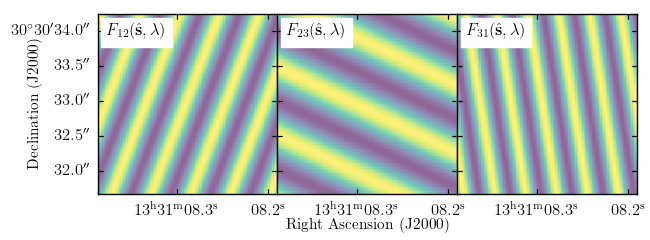

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_cal_orig_fringes.pdf


<IPython.core.display.Javascript object>


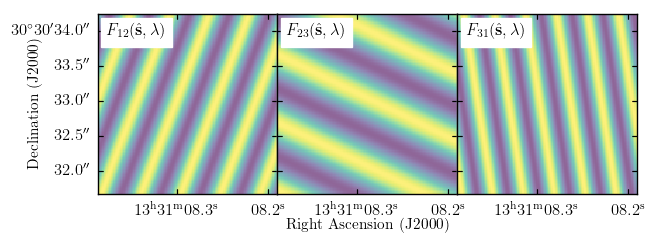

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_uncal_orig_fringes.pdf


In [98]:
fname = '0913.fits'
wcs = WCS(imghdrs_orig[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

for calkey in ['cal', 'uncal']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgfilenames_orig['bl-fringes'][calkey]):
        wcs = WCS(imghdrs_orig[fname]).celestial
        data = imgdata_orig[fname].squeeze()
        center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
        axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
    #     axs[fnamei].plot(wcs.wcs.crval[0]/15.0, wcs.wcs.crval[1], transform=axs[fnamei].transData, ls='none', marker='+', ms=8, color='black')
    #     axs[fnamei].scatter(wcs.wcs.crval[0], wcs.wcs.crval[1], transform=axs[fnamei].get_transform('world'), marker='+', s=16, color='black')
    #     axs[fnamei].scatter(center[0,0]-1, center[0,1], transform=axs[fnamei].get_transform('pixel'), marker='+', s=16, color='black')
#         axs[fnamei].text(center[0,0]-1, center[0,1], '+', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='black')
#         axs[fnamei].text(center[0,0]-1, center[0,1], 'O', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
        lon = axs[fnamei].coords[0]
        lat = axs[fnamei].coords[1]
        lon.set_major_formatter('hh:mm:ss.s')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
        if fnamei > 0:
            lat.set_ticklabel_visible(False)

    axs[0].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[1].text(0.05, 0.95, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[2].text(0.05, 0.95, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=12, color='black', backgroundcolor='white')

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=10)
    big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=40)

#     PLT.savefig(figdir+'3C286_individual_{0}_orig_fringes.pdf'.format(calkey), bbox_inches=0)
    print(figdir+'3C286_individual_{0}_orig_fringes.pdf'.format(calkey))

<IPython.core.display.Javascript object>


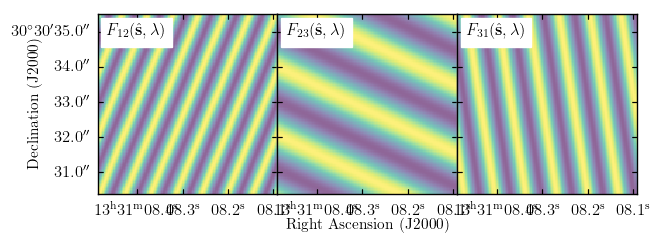

0922.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 202.7845332653  30.5091552377  
CRPIX : 65.0  65.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.111111111111e-05  1.111111111111e-05  
NAXIS : 128  128  1  1
0919.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 202.7845332653  30.5091552377  
CRPIX : 65.0  65.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -5.555555555556e-06  5.555555555556e-06  
NAXIS : 128  128  1  1
1319.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 202.7845332653  30.5091552377  
CRPIX : 65.0  65.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -5.555555555556e-06  5.555555555556e-06  
NAXIS : 128  128  1  1
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_cal_new_fringes.pdf


<IPython.core.display.Javascript object>


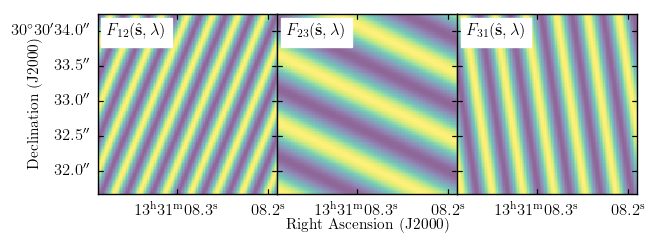

0922u.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 202.7845332653  30.5091552377  
CRPIX : 65.0  65.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.111111111111e-05  1.111111111111e-05  
NAXIS : 128  128  1  1
0919u.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 202.7845332653  30.5091552377  
CRPIX : 65.0  65.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -5.555555555556e-06  5.555555555556e-06  
NAXIS : 128  128  1  1
1319u.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 202.7845332653  30.5091552377  
CRPIX : 65.0  65.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -5.555555555556e-06  5.555555555556e-06  
NAXIS : 128  128  1  1
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_uncal_new_fringes.pdf


In [27]:
fname = '0922.fits'
wcs = WCS(imghdrs_new[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

for calkey in ['cal', 'uncal']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgfilenames_new['bl-fringes'][calkey]):
        print(fname)
        wcs = WCS(imghdrs_new[fname]).celestial
        print(wcs)
        data = imgdata_new[fname].squeeze()
        center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
        axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
    #     axs[fnamei].plot(wcs.wcs.crval[0]/15.0, wcs.wcs.crval[1], transform=axs[fnamei].transData, ls='none', marker='+', ms=8, color='black')
    #     axs[fnamei].scatter(wcs.wcs.crval[0], wcs.wcs.crval[1], transform=axs[fnamei].get_transform('world'), marker='+', s=16, color='black')
    #     axs[fnamei].scatter(center[0,0]-1, center[0,1], transform=axs[fnamei].get_transform('pixel'), marker='+', s=16, color='black')
#         axs[fnamei].text(center[0,0]-1, center[0,1], '+', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='black')
#         axs[fnamei].text(center[0,0]-1, center[0,1], 'O', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
        lon = axs[fnamei].coords[0]
        lat = axs[fnamei].coords[1]
        lon.set_major_formatter('hh:mm:ss.s')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
        if fnamei > 0:
            lat.set_ticklabel_visible(False)

    axs[0].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[1].text(0.05, 0.95, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[2].text(0.05, 0.95, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=12, color='black', backgroundcolor='white')

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=10)
    big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=40)

#     PLT.savefig(figdir+'3C286_individual_{0}_new_fringes.pdf'.format(calkey), bbox_inches=0)
    print(figdir+'3C286_individual_{0}_new_fringes.pdf'.format(calkey))

In [99]:
# fname = '0913.fits'
# wcs = WCS(imghdrs[fname]).celestial
# # center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

# for calkey in ['cal', 'uncal']:
#     fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(6.5,2.4))
#     for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
#         wcs = WCS(imghdrs[fname]).celestial
#         data = imgdata[fname].squeeze()
#         center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
#         axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#     #     axs[fnamei].plot(wcs.wcs.crval[0]/15.0, wcs.wcs.crval[1], transform=axs[fnamei].transData, ls='none', marker='+', ms=8, color='black')
#     #     axs[fnamei].scatter(wcs.wcs.crval[0], wcs.wcs.crval[1], transform=axs[fnamei].get_transform('world'), marker='+', s=16, color='black')
#     #     axs[fnamei].scatter(center[0,0]-1, center[0,1], transform=axs[fnamei].get_transform('pixel'), marker='+', s=16, color='black')
# #         axs[fnamei].text(center[0,0]-1, center[0,1], '+', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='black')
# #         axs[fnamei].text(center[0,0]-1, center[0,1], 'O', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
#         lon = axs[fnamei].coords[0]
#         lat = axs[fnamei].coords[1]
#         lon.set_major_formatter('hh:mm:ss.s')
#         lat.set_major_formatter('dd:mm:ss.s')
#         lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
#         lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
#         if fnamei > 0:
#             lat.set_ticklabel_visible(False)

#     axs[0].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=10, color='black', backgroundcolor='white')
#     axs[1].text(0.05, 0.95, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=10, color='black', backgroundcolor='white')
#     axs[2].text(0.05, 0.95, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=10, color='black', backgroundcolor='white')

#     fig.subplots_adjust(hspace=0, wspace=0)
#     fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

#     big_ax = fig.add_subplot(111)
#     big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
#     # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
#     big_ax.spines['right'].set_visible(False)
#     big_ax.spines['top'].set_visible(False)
#     big_ax.spines['left'].set_visible(False)
#     big_ax.spines['bottom'].set_visible(False)
#     big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#     big_ax.set_xticks([])
#     big_ax.set_yticks([])
#     big_ax.set_xlabel('Right Ascension (J2000)', fontsize=10, weight='medium', labelpad=10)
#     big_ax.set_ylabel('Declination (J2000)', fontsize=10, weight='medium', labelpad=40)

#     # PLT.savefig(figdir+'3C286_individual_{0}_fringes.pdf'.format(calkey), bbox_inches=0)
#     print(figdir+'3C286_individual_{0}_fringes.pdf'.format(calkey))

# Plot the three calibrated fringes together for 3C286 with and without calibration

<IPython.core.display.Javascript object>


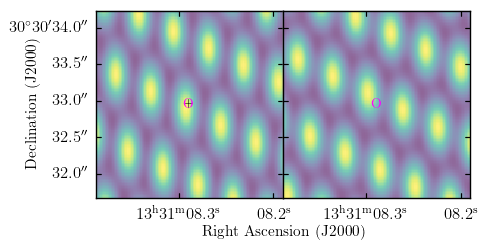

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_orig.pdf


In [100]:
# fname = '0913.fits'
fname = '3fringecal.fits'
wcs = WCS(imghdrs_orig[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(4.8,2.4))

for calind, calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames_orig['triad-fringes'][calkey]
    wcs = WCS(imghdrs_orig[fname]).celestial
    center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
    data = imgdata_orig[fname].squeeze()
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#     axs[calind].plot(wcs.wcs.crval[0]/15.0, wcs.wcs.crval[1], transform=axs[calind].transData, ls='none', marker='+', ms=8, color='black')
#     axs[calind].scatter(wcs.wcs.crval[0], wcs.wcs.crval[1], transform=axs[calind].get_transform('world'), marker='+', s=16, color='black')
    if calkey == 'cal':
#         axs[calind].scatter(center[0,0]-1, center[0,1], transform=axs[calind].get_transform('pixel'), marker='+', s=16, color='black')
        axs[calind].text(center[0,0]-1, center[0,1], '+', transform=axs[calind].get_transform('pixel'), ha='center', va='center', fontsize=10, color='black')
        axs[calind].text(center[0,0]-1, center[0,1], 'O', transform=axs[calind].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
    if calkey == 'uncal':
        axs[calind].text(center[0,0]-1, center[0,1], 'O', transform=axs[calind].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
    lon = axs[calind].coords[0]
    lat = axs[calind].coords[1]
    lon.set_major_formatter('hh:mm:ss.s')
    lat.set_major_formatter('dd:mm:ss.s')
    lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
    lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
    if calind > 0:
        lat.set_ticklabel_visible(False)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=15)
big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=40)

# PLT.savefig(figdir+'3C286_all_fringes_orig.pdf', bbox_inches=0)
print(figdir+'3C286_all_fringes_orig.pdf')

<IPython.core.display.Javascript object>


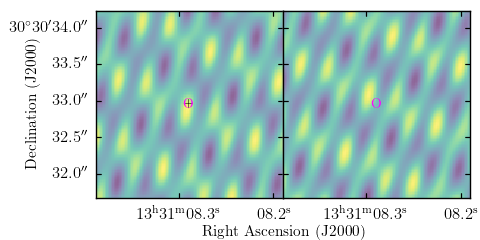

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_new.pdf


In [101]:
# fname = '0913.fits'
fname = '3fringecal.fits'
wcs = WCS(imghdrs_new[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(4.8,2.4))

for calind, calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames_new['triad-fringes'][calkey]
    wcs = WCS(imghdrs_new[fname]).celestial
    center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
    data = imgdata_new[fname].squeeze() 
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#     axs[calind].plot(wcs.wcs.crval[0]/15.0, wcs.wcs.crval[1], transform=axs[calind].transData, ls='none', marker='+', ms=8, color='black')
#     axs[calind].scatter(wcs.wcs.crval[0], wcs.wcs.crval[1], transform=axs[calind].get_transform('world'), marker='+', s=16, color='black')
    if calkey == 'cal':
#         axs[calind].scatter(center[0,0]-1, center[0,1], transform=axs[calind].get_transform('pixel'), marker='+', s=16, color='black')
        axs[calind].text(center[0,0]-1, center[0,1], '+', transform=axs[calind].get_transform('pixel'), ha='center', va='center', fontsize=10, color='black')
        axs[calind].text(center[0,0]-1, center[0,1], 'O', transform=axs[calind].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
    if calkey == 'uncal':
        axs[calind].text(center[0,0]-1, center[0,1], 'O', transform=axs[calind].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
    lon = axs[calind].coords[0]
    lat = axs[calind].coords[1]
    lon.set_major_formatter('hh:mm:ss.s')
    lat.set_major_formatter('dd:mm:ss.s')
    lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
    lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
    if calind > 0:
        lat.set_ticklabel_visible(False)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=15)
big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=40)

# PLT.savefig(figdir+'3C286_all_fringes_new.pdf', bbox_inches=0)
print(figdir+'3C286_all_fringes_new.pdf')

<IPython.core.display.Javascript object>


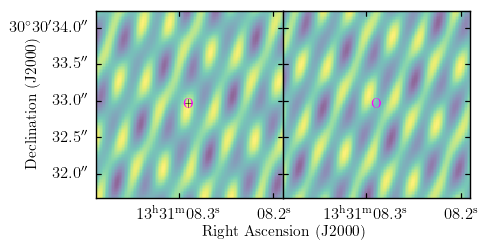

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_new_orig_diff.pdf


In [102]:
## Plot of the difference between the triple fringe combinations

# fname = '0913.fits'
fname = '3fringecal.fits'
wcs = WCS(imghdrs_new[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(4.8,2.4))

for calind, calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames_new['triad-fringes'][calkey]
    wcs = WCS(imghdrs_new[fname]).celestial
    center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
    data = imgdata_new[fname].squeeze() - imgdata_orig[fname].squeeze()
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#     axs[calind].plot(wcs.wcs.crval[0]/15.0, wcs.wcs.crval[1], transform=axs[calind].transData, ls='none', marker='+', ms=8, color='black')
#     axs[calind].scatter(wcs.wcs.crval[0], wcs.wcs.crval[1], transform=axs[calind].get_transform('world'), marker='+', s=16, color='black')
    if calkey == 'cal':
#         axs[calind].scatter(center[0,0]-1, center[0,1], transform=axs[calind].get_transform('pixel'), marker='+', s=16, color='black')
        axs[calind].text(center[0,0]-1, center[0,1], '+', transform=axs[calind].get_transform('pixel'), ha='center', va='center', fontsize=10, color='black')
        axs[calind].text(center[0,0]-1, center[0,1], 'O', transform=axs[calind].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
    if calkey == 'uncal':
        axs[calind].text(center[0,0]-1, center[0,1], 'O', transform=axs[calind].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
    lon = axs[calind].coords[0]
    lat = axs[calind].coords[1]
    lon.set_major_formatter('hh:mm:ss.s')
    lat.set_major_formatter('dd:mm:ss.s')
    lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
    lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
    if calind > 0:
        lat.set_ticklabel_visible(False)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=15)
big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=40)

# PLT.savefig(figdir+'3C286_all_fringes_new_orig_diff.pdf', bbox_inches=0)
print(figdir+'3C286_all_fringes_new_orig_diff.pdf')

# Plot the three calibrated two-fringe combinations for 3C286

<IPython.core.display.Javascript object>


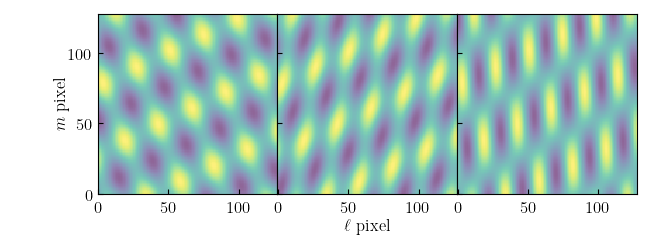

(0, '0913+0919')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_orig_individual_cal_two-fringes-0913+0919.pdf
(1, '0919+1319')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_orig_individual_cal_two-fringes-0919+1319.pdf
(2, '1319+0913')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_orig_individual_cal_two-fringes-1319+0913.pdf


/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


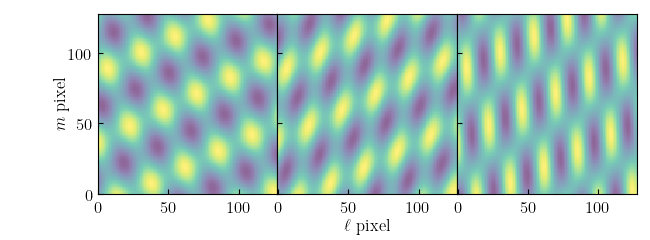

(0, '0913u+0919u')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_orig_individual_uncal_two-fringes-0913u+0919u.pdf
(1, '0919u+1319u')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_orig_individual_uncal_two-fringes-0919u+1319u.pdf
(2, '1319u+0913u')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_orig_individual_uncal_two-fringes-1319u+0913u.pdf


In [31]:
fname = '0913.fits'
wcs = WCS(imghdrs_orig[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

for calkey in ['cal', 'uncal']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgdata_orig['two-fringes'][calkey]):
        print(fnamei, fname)
    #     fig, ax = PLT.subplots(nrows=1, ncols=1, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(2.4,2.4))

        data = imgdata_orig['two-fringes'][calkey][fname].squeeze()[:,::-1] # Flip the x-axis (second axis in this case)
        axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
    #     axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)

    #     axs[fnamei].text(center[0,0]-1, center[0,1], '+', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='black')
    #     axs[fnamei].text(center[0,0]-1, center[0,1], 'O', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')

    #     axs[fnamei].text(center[0,0]-1, center[0,1], 'O', transform=axs[fnamei].transData, ha='center', va='center', fontsize=10, color='magenta')

    #     lon = axs[fnamei].coords[0]
    #     lat = axs[fnamei].coords[1]
    #     lon.set_major_formatter('hh:mm:ss.s')
    #     lat.set_major_formatter('dd:mm:ss.s')
    #     lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
    #     lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
    #     if fnamei > 0:
    #         lat.set_ticklabel_visible(False)

    #     axs[0].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)+F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=10, color='black', backgroundcolor='white')
    #     axs[1].text(0.05, 0.95, r'$F_{23}(\hat{\mathbf{s}},\lambda)+F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=10, color='black', backgroundcolor='white')
    #     axs[2].text(0.05, 0.95, r'$F_{31}(\hat{\mathbf{s}},\lambda)+F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=10, color='black', backgroundcolor='white')

        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
        # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
        big_ax.spines['right'].set_visible(False)
        big_ax.spines['top'].set_visible(False)
        big_ax.spines['left'].set_visible(False)
        big_ax.spines['bottom'].set_visible(False)
        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$\ell$ pixel', fontsize=12, weight='medium', labelpad=10)
        big_ax.set_ylabel(r'$m$ pixel', fontsize=12, weight='medium', labelpad=20)

        # PLT.savefig(figdir+'3C286_orig_individual_{0}_two-fringes-{1}.pdf'.format(calkey, fname), bbox_inches=0)
        print(figdir+'3C286_orig_individual_{0}_two-fringes-{1}.pdf'.format(calkey, fname))

<IPython.core.display.Javascript object>


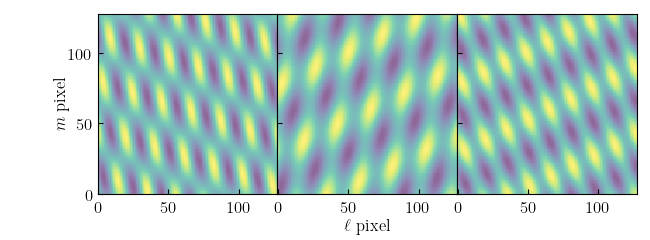

(0, '1319+0922')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_new_individual_cal_two-fringes-1319+0922.pdf
(1, '0919+1319')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_new_individual_cal_two-fringes-0919+1319.pdf
(2, '0922+0919')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_new_individual_cal_two-fringes-0922+0919.pdf


<IPython.core.display.Javascript object>


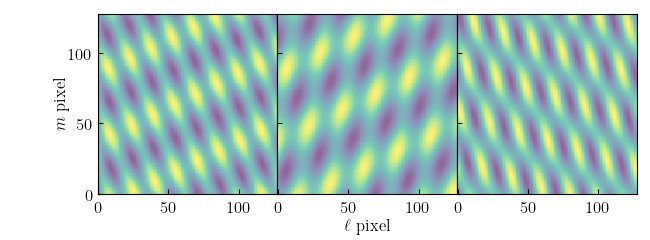

(0, '0922u+0919u')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_new_individual_uncal_two-fringes-0922u+0919u.pdf
(1, '0919u+1319u')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_new_individual_uncal_two-fringes-0919u+1319u.pdf
(2, '1319u+0922u')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_new_individual_uncal_two-fringes-1319u+0922u.pdf


In [32]:
fname = '0922.fits'
wcs = WCS(imghdrs_new[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

for calkey in ['cal', 'uncal']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgdata_new['two-fringes'][calkey]):
        print(fnamei, fname)
    #     fig, ax = PLT.subplots(nrows=1, ncols=1, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(2.4,2.4))

        data = imgdata_new['two-fringes'][calkey][fname].squeeze()[:,::-1] # Flip the x-axis (second axis in this case)
        axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
    #     axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)

    #     axs[fnamei].text(center[0,0]-1, center[0,1], '+', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='black')
    #     axs[fnamei].text(center[0,0]-1, center[0,1], 'O', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')

    #     axs[fnamei].text(center[0,0]-1, center[0,1], 'O', transform=axs[fnamei].transData, ha='center', va='center', fontsize=10, color='magenta')

    #     lon = axs[fnamei].coords[0]
    #     lat = axs[fnamei].coords[1]
    #     lon.set_major_formatter('hh:mm:ss.s')
    #     lat.set_major_formatter('dd:mm:ss.s')
    #     lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
    #     lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
    #     if fnamei > 0:
    #         lat.set_ticklabel_visible(False)

    #     axs[0].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)+F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=10, color='black', backgroundcolor='white')
    #     axs[1].text(0.05, 0.95, r'$F_{23}(\hat{\mathbf{s}},\lambda)+F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=10, color='black', backgroundcolor='white')
    #     axs[2].text(0.05, 0.95, r'$F_{31}(\hat{\mathbf{s}},\lambda)+F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=10, color='black', backgroundcolor='white')

        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
        # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
        big_ax.spines['right'].set_visible(False)
        big_ax.spines['top'].set_visible(False)
        big_ax.spines['left'].set_visible(False)
        big_ax.spines['bottom'].set_visible(False)
        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$\ell$ pixel', fontsize=12, weight='medium', labelpad=10)
        big_ax.set_ylabel(r'$m$ pixel', fontsize=12, weight='medium', labelpad=20)

        # PLT.savefig(figdir+'3C286_new_individual_{0}_two-fringes-{1}.pdf'.format(calkey, fname), bbox_inches=0)
        print(figdir+'3C286_new_individual_{0}_two-fringes-{1}.pdf'.format(calkey, fname))

In [90]:
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 202.7845332653  30.5091552377  
CRPIX : 65.0  65.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -5.555555555556e-06  5.555555555556e-06  
NAXIS : 128  128  1  1


In [64]:
imghdrs['0919.fits']['NAXIS1']

128

In [65]:
wcs.wcs.crval

array([202.78453327,  30.50915524])

In [66]:
(wcs.wcs.crval - 13.5166666666666667* 15.0)/15 * 3600

array([ 8.28798367e+00, -4.13378027e+04])

In [67]:
wcs.wcs.crpix

array([65., 65.])

In [68]:
wcs.wcs.cunit

['deg', 'deg']

## PSF tests

In [58]:
sampling1d = NP.zeros((2,1024), dtype=NP.float)
sampling1d[0,[16, 48, 64]] = 1.0
sampling1d[1,[16, 50, 64]] = 1.0
psf1d = NP.fft.fftshift(NP.fft.fft(sampling1d, axis=1), axes=1)

In [59]:
print(sampling1d[:,:65])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [60]:
fig = PLT.figure()
ax = fig.add_subplot(111)
ax.plot(psf1d[0,:].real, ls='-', color='black')
ax.plot(psf1d[1,:].real, ls='-', color='red')

<IPython.core.display.Javascript object>

In [80]:
sampling2d_ideal = 10*NP.asarray([[16,0], [48,32], [-64,-32]], dtype=NP.float)
sampling2d_nonideal = 10*NP.asarray([[16,0], [50,33], [-64,-32]], dtype=NP.float)
psf2d_gridx, psf2d_gridy = NP.meshgrid(NP.arange(1024), NP.arange(1024))
psf2d_grid_raveled = NP.vstack((psf2d_gridx.reshape(1,-1), psf2d_gridy.reshape(1,-1)))
# dotproduct_ideal = 
psf2d_ideal = NP.sum(NP.exp(-1j*2*NP.pi*NP.dot(sampling2d_ideal, psf2d_grid_raveled)/psf2d_gridx.size), axis=0).reshape(psf2d_gridx.shape)
psf2d_nonideal = NP.sum(NP.exp(-1j*2*NP.pi*NP.dot(sampling2d_nonideal, psf2d_grid_raveled)/psf2d_gridx.size), axis=0).reshape(psf2d_gridx.shape)

<IPython.core.display.Javascript object>


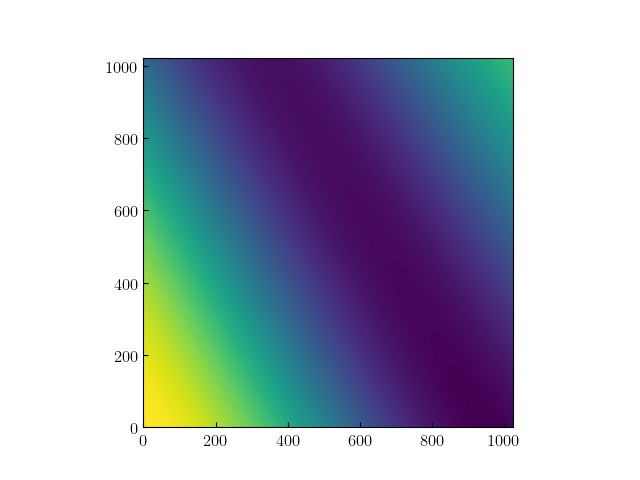

<IPython.core.display.Javascript object>


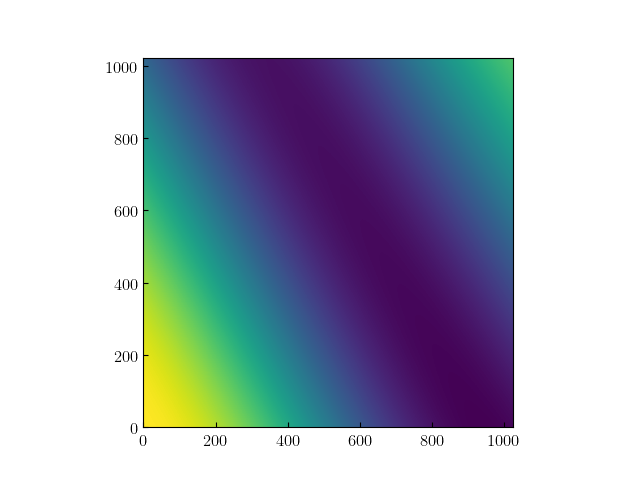

<IPython.core.display.Javascript object>

In [81]:
fig = PLT.figure()
ax = fig.add_subplot(111)
ax.imshow(psf2d_ideal.real, origin='lower')

fig = PLT.figure()
ax = fig.add_subplot(111)
ax.imshow(psf2d_nonideal.real, origin='lower')

fig = PLT.figure()
ax = fig.add_subplot(111)
ax.imshow(psf2d_ideal.real - psf2d_nonideal.real, origin='lower')

In [104]:
print(psf2d_ideal.real.max())

3.0


## Read visibility information

In [69]:
# visdir = '/lustre/aoc/users/nthyagar/projects/CPhaseGeom/data/3C286/UV/4min/'
# visfile = '3C286_RR_3fringe_4min.uvfits'
# visobj = UVData()
# visobj.read_uvfits(visdir+visfile)

visdir = '/lustre/aoc/users/nthyagar/projects/CPhaseGeom/data/3C286/UV/20sec/'
visfile = '3C286_snapshot_long_baseline.uvfits'
visobj = UVData()
visobj.read_uvfits(visdir+visfile)

time_array = visobj.time_array.reshape(visobj.Ntimes,visobj.Nbls)
unique_times = time_array[:,0]
nchan = visobj.freq_array.size
snap_visobj = visobj.select(times=unique_times[int(0.5*visobj.Ntimes)], inplace=False)

f0 = visobj.freq_array.ravel()[int(0.5*nchan)]
wl0 = (FCNST.c / (f0 * U.Hz)).to('m')
antpos_data, antid_data = snap_visobj.get_ENU_antpos()
antpos_data = antpos_data * U.m
blvect_data = NP.roll(antpos_data, -1, axis=0) - antpos_data
bll_data = NP.sqrt(NP.sum(blvect_data**2, axis=1))
uvvect_data = blvect_data / wl0
uvw_data = snap_visobj.uvw_array

fringe_slopes_data = -uvw_data[:,0] / uvw_data[:,1]

vis_snr = 4.4e3 / 33 # SNR on each visibility
phase_err = 1/vis_snr # in radians
pos_err = phase_err / (2 * NP.pi * NP.sqrt(NP.sum(uvw_data[:,:2]**2, axis=1)) / wl0.to('m').value) # in radians

# visdir = '/lustre/aoc/users/nthyagar/projects/CPhaseGeom/data/3C286/UV/20sec/'
# uncal_visfile = '3C286uncal.uvfits'
# cal_visfile = '3C286cal.uvfits'
# antids = [8, 12, 18]

# cal_visobj = UVData()
# cal_visobj.read_uvfits(visdir+cal_visfile)
# uncal_visobj = UVData()
# uncal_visobj.read_uvfits(visdir+uncal_visfile)
# nchan = uncal_visobj.freq_array.size
# f0 = uncal_visobj.freq_array.ravel()[int(0.5*nchan)]
# wl0 = (FCNST.c / (f0 * U.Hz)).to('m')
# antpos_data, antid_data = uncal_visobj.get_ENU_antpos()
# antpos_data = antpos_data * U.m
# blvect_data = NP.roll(antpos_data, -1, axis=0) - antpos_data
# bll_data = NP.sqrt(NP.sum(blvect_data**2, axis=1))
# uvvect_data = blvect_data / wl0

Telescope EVLA is not in known_telescopes.


In [70]:
print(nchan)
print(visobj.Nbls)
print(visobj.Ntimes)
print(antpos_data)
print(visobj.antenna_numbers)
print(visobj.antenna_names)
print(visobj.data_array.shape)
# print(visobj.freq_array.shape)
# print(visobj.time_array.shape)
# print(visobj.integration_time)
print(visobj.time_array.reshape(visobj.Ntimes,visobj.Nbls))
print(visobj.uvw_array.shape)
print(NP.sqrt(NP.sum(visobj.uvw_array[:,:2]**2, axis=1)))
print(visobj.polarization_array)
print(blvect_data)
print(bll_data)
print(uvvect_data.decompose())
print(NP.sqrt(NP.sum(uvvect_data**2, axis=1)).decompose().value)
print(1/NP.sqrt(NP.sum(uvvect_data**2, axis=1)).decompose().value)
# uncal_visobj.select(antenna_nums=antids)
print(zip(snap_visobj.ant_1_array, snap_visobj.ant_2_array))
print(snap_visobj.data_array.shape)
print(snap_visobj.uvw_array)
print(NP.sqrt(NP.sum(uvw_data[:,:2]**2, axis=1)))
print(1/NP.sqrt(NP.sum(uvvect_data[:,:2]**2, axis=1)))
print(fringe_slopes)
print(vis_snr)
print(phase_err)
print(NP.degrees(pos_err) * 3.6e3 * 1e3) # in mas

1
3
10
[[ 0.00000000e+00  4.66383592e+03  0.00000000e+00]
 [-1.11850472e+04 -4.39552907e+03 -1.07725328e+01]
 [ 7.06781502e+03  0.00000000e+00  3.00774909e+01]] m
[ 8 12 18]
['N16\x00\x00\x00\x00\xf0', 'W56\x00\x00\x00\x00\xf0', 'E40\x00\x00\x00\x00\xf0']
(30, 1, 1, 4)
[[2458733.28126156 2458733.28126156 2458733.28126156]
 [2458733.28128472 2458733.28128472 2458733.28128472]
 [2458733.28130788 2458733.28130788 2458733.28130788]
 [2458733.28133103 2458733.28133103 2458733.28133103]
 [2458733.28135416 2458733.28135416 2458733.28135416]
 [2458733.28137732 2458733.28137732 2458733.28137732]
 [2458733.28140047 2458733.28140047 2458733.28140047]
 [2458733.2814236  2458733.2814236  2458733.2814236 ]
 [2458733.28144675 2458733.28144675 2458733.28144675]
 [2458733.28146991 2458733.28146991 2458733.28146991]]
(30, 3)
[12387.176   7509.7036 15035.858  12388.036   7509.919  15037.255
 12388.898   7510.134  15038.651  12389.76    7510.348  15040.049
 12390.621   7510.5625 15041.444  12391.4795  751

In [71]:
xy_center = {}
xy_std = {}
xy_blc = {}
xy_trc = {}
xy_center['cal'] = {'0913+0919': NP.asarray([66.5, 60.5]), '0919+1319': NP.asarray([66.5, 60.5]), '1319+0913': NP.asarray([66.5, 60.5])}
xy_std['cal'] = {'0913+0919': NP.asarray([3.0, 6.0]), '0919+1319': NP.asarray([3.0, 6.0]), '1319+0913': NP.asarray([3.0, 6.0])}
xy_blc['cal'] = {'0913+0919': NP.asarray([56, 44]), '0919+1319': NP.asarray([55, 38]), '1319+0913': NP.asarray([55, 38])}
xy_trc['cal'] = {'0913+0919': NP.asarray([77, 77]), '0919+1319': NP.asarray([78, 83]), '1319+0913': NP.asarray([78, 83])}

xy_center['uncal'] = {'0913u+0919u': NP.asarray([70.0, 70.0]), '0919u+1319u': NP.asarray([70.0, 70.0]), '1319u+0913u': NP.asarray([70.0, 70.0])}
xy_std['uncal'] = {'0913u+0919u': NP.asarray([3.0, 6.0]), '0919u+1319u': NP.asarray([3.0, 6.0]), '1319u+0913u': NP.asarray([3.0, 6.0])}
xy_blc['uncal'] = {'0913u+0919u': NP.asarray([59, 51]), '0919u+1319u': NP.asarray([59, 51]), '1319u+0913u': NP.asarray([59, 51])}
xy_trc['uncal'] = {'0913u+0919u': NP.asarray([81, 89]), '0919u+1319u': NP.asarray([81, 89]), '1319u+0913u': NP.asarray([81, 89])}

print(xy_blc['cal'])
print(xy_trc['cal'])
print(xy_blc['uncal'])
print(xy_trc['uncal'])

{'0913+0919': array([56, 44]), '0919+1319': array([55, 38]), '1319+0913': array([55, 38])}
{'0913+0919': array([77, 77]), '0919+1319': array([78, 83]), '1319+0913': array([78, 83])}
{'0913u+0919u': array([59, 51]), '0919u+1319u': array([59, 51]), '1319u+0913u': array([59, 51])}
{'0913u+0919u': array([81, 89]), '0919u+1319u': array([81, 89]), '1319u+0913u': array([81, 89])}


In [72]:
astropy_lmfit_output = {}
astropy_lmfitter = fitting.LevMarLSQFitter()

for calkey in ['cal', 'uncal']:
    astropy_lmfit_output[calkey] = {}
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
    #     print(xy_blc[fname][0], xy_trc[fname][0]+1)
    #     print(NP.arange(xy_blc[fname][0], xy_trc[fname][0]+1))
    #     print(NP.arange(xy_blc[fname][1], xy_trc[fname][1]+1))
        print(fname)
        xgrid, ygrid = NP.meshgrid(NP.arange(xy_blc[calkey][fname][0], xy_trc[calkey][fname][0]+1), NP.arange(xy_blc[calkey][fname][1], xy_trc[calkey][fname][1]+1))
        data_full = imgdata['two-fringes'][calkey][fname].squeeze()[:,::-1] 
        data_subset = data_full[xy_blc[calkey][fname][1]:xy_trc[calkey][fname][1]+1, xy_blc[calkey][fname][0]:xy_trc[calkey][fname][0]+1]
        g2d_model = models.Gaussian2D(x_mean=xy_center[calkey][fname][0], y_mean=xy_center[calkey][fname][1], x_stddev=xy_std[calkey][fname][0], y_stddev=xy_std[calkey][fname][1], theta=0.0)
        g2p = astropy_lmfitter(g2d_model, xgrid, ygrid, data_subset)
        astropy_lmfit_output[calkey][fname] = {}
        astropy_lmfit_output[calkey][fname]['data'] = NP.copy(data_subset)
        astropy_lmfit_output[calkey][fname]['parameters'] = {'amplitude': g2p.amplitude.value, 'x_center': g2p.x_mean.value, 'y_center': g2p.y_mean.value, 'x_std': g2p.x_stddev.value, 'y_std': g2p.y_stddev.value, 'theta': g2p.theta.value, }
        astropy_lmfit_output[calkey][fname]['modelfit'] = g2p(xgrid, ygrid)
        print(fname+': ', astropy_lmfit_output[calkey][fname]['parameters'])

0913+0919
('0913+0919: ', {'x_std': 4.55063030597578, 'y_std': 7.434786406827039, 'x_center': 66.39981132523327, 'amplitude': 9.989625876937037, 'theta': 0.36161761479677756, 'y_center': 60.68990569037199})
0919+1319
('0919+1319: ', {'x_std': 3.318080027950619, 'y_std': 9.21725899517596, 'x_center': 66.28559525967782, 'amplitude': 10.556603655003487, 'theta': -0.28955847778613725, 'y_center': 60.61065869270151})
1319+0913
('1319+0913: ', {'x_std': 2.75155972110493, 'y_std': 12.293355504483491, 'x_center': 66.3272935316513, 'amplitude': 10.02597202058405, 'theta': 0.04583637564930524, 'y_center': 60.918869626086504})
0913u+0919u
('0913u+0919u: ', {'x_std': 5.259348891036416, 'y_std': 6.376651366353596, 'x_center': 69.71271735508172, 'amplitude': 0.23314946784149226, 'theta': 0.3632279340153734, 'y_center': 70.97865775204487})
0919u+1319u
('0919u+1319u: ', {'x_std': 3.735507464524421, 'y_std': 8.856084563241447, 'x_center': 69.61623684157792, 'amplitude': 0.23649899498569915, 'theta': -0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


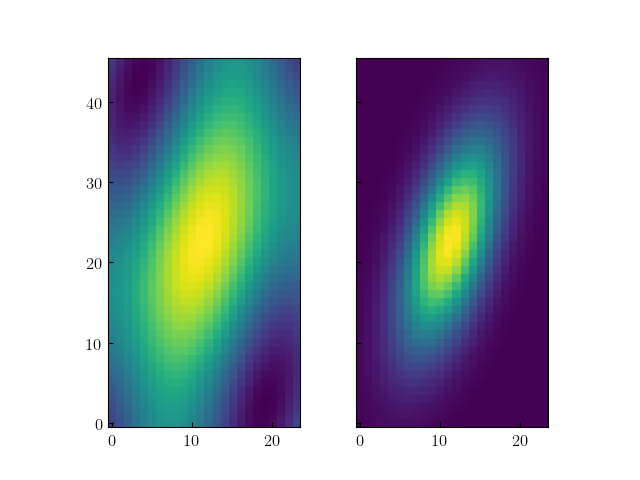

<IPython.core.display.Javascript object>


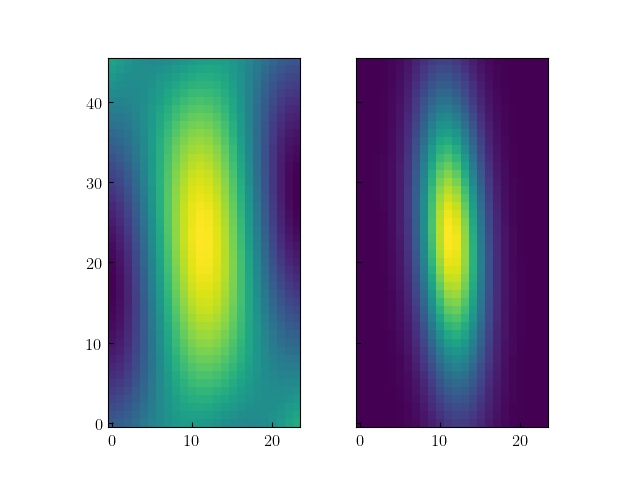

<IPython.core.display.Javascript object>


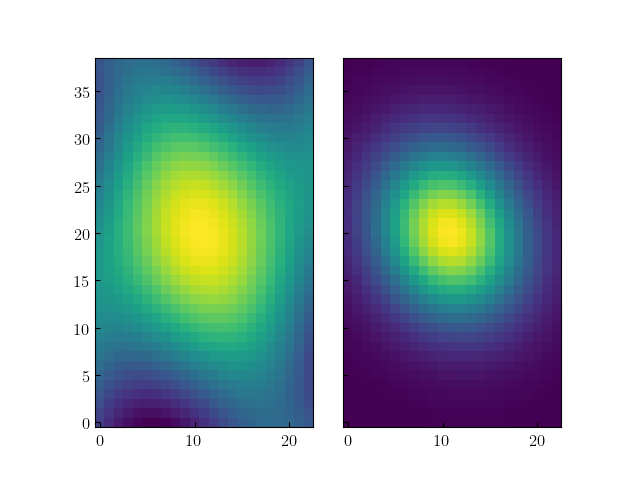

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
for calkey in ['cal', 'uncal']:
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True)
        axs[0].imshow(astropy_lmfit_output[calkey][fname]['data'], origin='lower')
        axs[1].imshow(astropy_lmfit_output[calkey][fname]['modelfit'], origin='lower')
        fig.subplots_adjust(hspace=0, wspace=0)

In [75]:
scipy_fit_output_1 = {}
for calkey in ['cal', 'uncal']:
    scipy_fit_output_1[calkey] = {}
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        xgrid, ygrid = NP.meshgrid(NP.arange(xy_blc[calkey][fname][0], xy_trc[calkey][fname][0]+1), NP.arange(xy_blc[calkey][fname][1], xy_trc[calkey][fname][1]+1))
        data_full = imgdata['two-fringes'][calkey][fname].squeeze()[:,::-1] 
        data_subset = data_full[xy_blc[calkey][fname][1]:xy_trc[calkey][fname][1]+1, xy_blc[calkey][fname][0]:xy_trc[calkey][fname][0]+1]
        initial_guess = (10.0, xy_center[calkey][fname][0], xy_center[calkey][fname][1], xy_std[calkey][fname][0], xy_std[calkey][fname][1], 0.0)    
        popt, pcov = OPT.curve_fit(gaussian2D_without_offset, (xgrid, ygrid), data_subset.ravel(), p0=initial_guess)
        scipy_fit_output_1[calkey][fname] = {}
        scipy_fit_output_1[calkey][fname]['data'] = NP.copy(data_subset)
        scipy_fit_output_1[calkey][fname]['parameters'] = {'amplitude': popt[0], 'x_center': popt[1], 'y_center': popt[2], 'x_std': popt[3], 'y_std': popt[4], 'theta': popt[5]}
        scipy_fit_output_1[calkey][fname]['covariance'] = NP.copy(pcov)
        scipy_fit_output_1[calkey][fname]['modelfit'] = gaussian2D_without_offset((xgrid, ygrid), scipy_fit_output_1[calkey][fname]['parameters']['amplitude'], scipy_fit_output_1[calkey][fname]['parameters']['x_center'], scipy_fit_output_1[calkey][fname]['parameters']['y_center'], scipy_fit_output_1[calkey][fname]['parameters']['x_std'], scipy_fit_output_1[calkey][fname]['parameters']['y_std'], scipy_fit_output_1[calkey][fname]['parameters']['theta']).reshape(xgrid.shape)
        print('-----{0}-----'.format(fname))
        print('    Optimum values:    ', popt)
        print('    Diagstd:    ', NP.sqrt(NP.diagonal(pcov)))
        print('    Covariance:    ', pcov[1:3,1:3])   

-----0913+0919-----
('    Optimum values:    ', array([ 9.98978655, 66.39981171, 60.68990823,  4.55053918,  7.43469448,
       -0.36165335]))
('    Diagstd:    ', array([0.18850448, 0.09405616, 0.13355706, 0.08759084, 0.1431722 ,
       0.02656066]))
('    Covariance:    ', array([[ 0.00884656, -0.00407383],
       [-0.00407383,  0.01783749]]))
-----0919+1319-----
('    Optimum values:    ', array([10.55712033, 66.28559649, 60.61066042,  3.31773916,  9.21730326,
        0.28961169]))
('    Diagstd:    ', array([0.51020754, 0.19908133, 0.42892215, 0.16010355, 0.45009196,
       0.02828188]))
('    Covariance:    ', array([[0.03963338, 0.04718251],
       [0.04718251, 0.18397421]]))
-----1319+0913-----
('    Optimum values:    ', array([ 1.00260823e+01,  6.63272935e+01,  6.09188693e+01,  2.75149921e+00,
        1.22933555e+01, -4.58375493e-02]))
('    Diagstd:    ', array([0.4570679 , 0.12525063, 0.5661132 , 0.1226749 , 0.63652098,
       0.01535611]))
('    Covariance:    ', array([[ 0.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


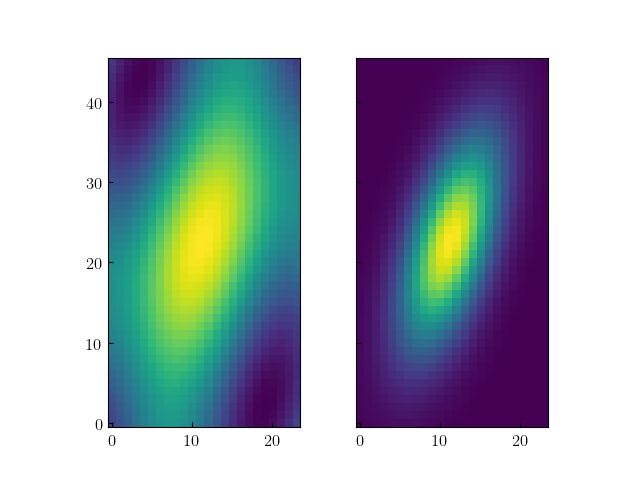

<IPython.core.display.Javascript object>


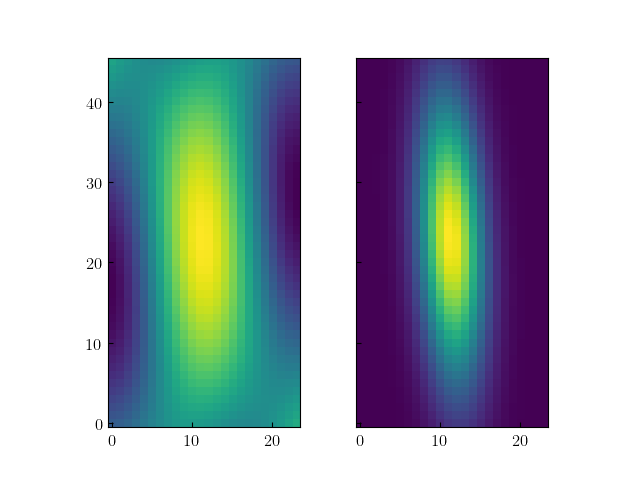

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


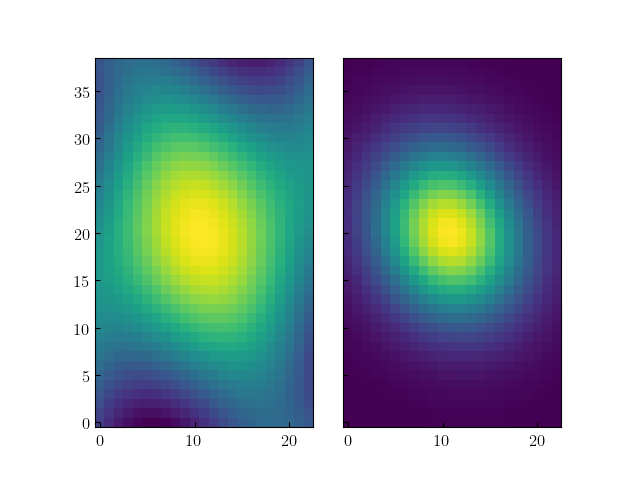

<IPython.core.display.Javascript object>


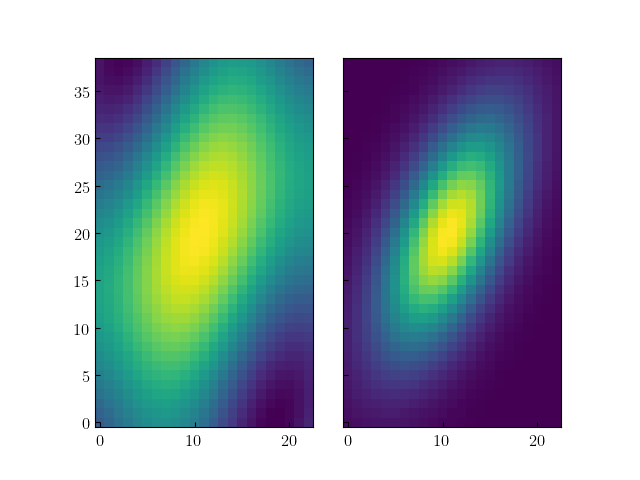

<IPython.core.display.Javascript object>


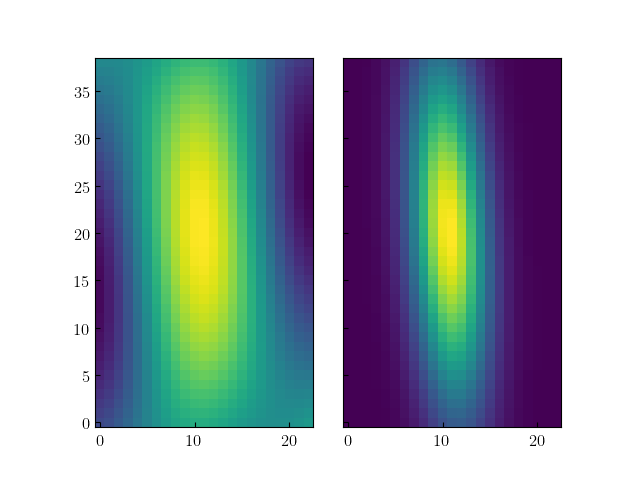

In [76]:
for calkey in ['cal', 'uncal']:
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True)
        axs[0].imshow(scipy_fit_output_1[calkey][fname]['data'], origin='lower')
        axs[1].imshow(scipy_fit_output_1[calkey][fname]['modelfit'], origin='lower')
        fig.subplots_adjust(hspace=0, wspace=0)

In [78]:
scipy_fit_output_2 = {}
for calkey in ['cal', 'uncal']:
    scipy_fit_output_2[calkey] = {}
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        xgrid, ygrid = NP.meshgrid(NP.arange(xy_blc[calkey][fname][0], xy_trc[calkey][fname][0]+1), NP.arange(xy_blc[calkey][fname][1], xy_trc[calkey][fname][1]+1))
        data_full = imgdata['two-fringes'][calkey][fname].squeeze()[:,::-1] 
        data_subset = data_full[xy_blc[calkey][fname][1]:xy_trc[calkey][fname][1]+1, xy_blc[calkey][fname][0]:xy_trc[calkey][fname][0]+1]
        initial_guess = (10.0, xy_center[calkey][fname][0], xy_center[calkey][fname][1], xy_std[calkey][fname][0], xy_std[calkey][fname][1], 0.0, 0.0)    
        popt, pcov = OPT.curve_fit(gaussian2D_with_offset, (xgrid, ygrid), data_subset.ravel(), p0=initial_guess)
        scipy_fit_output_2[calkey][fname] = {}
        scipy_fit_output_2[calkey][fname]['data'] = NP.copy(data_subset)
        scipy_fit_output_2[calkey][fname]['parameters'] = {'amplitude': popt[0], 'x_center': popt[1], 'y_center': popt[2], 'x_std': popt[3], 'y_std': popt[4], 'theta': popt[5], 'offset': popt[6]}
        scipy_fit_output_2[calkey][fname]['covariance'] = NP.copy(pcov)
        scipy_fit_output_2[calkey][fname]['modelfit'] = gaussian2D_with_offset((xgrid, ygrid), scipy_fit_output_2[calkey][fname]['parameters']['amplitude'], scipy_fit_output_2[calkey][fname]['parameters']['x_center'], scipy_fit_output_2[calkey][fname]['parameters']['y_center'], scipy_fit_output_2[calkey][fname]['parameters']['x_std'], scipy_fit_output_2[calkey][fname]['parameters']['y_std'], scipy_fit_output_2[calkey][fname]['parameters']['theta'], scipy_fit_output_2[calkey][fname]['parameters']['offset']).reshape(xgrid.shape)
        print('-----{0}-----'.format(fname))
        print('    Optimum values:    ', popt)
        print('    Diagstd:    ', NP.sqrt(NP.diagonal(pcov)))
        print('    Covariance:    ', pcov[1:3,1:3])

-----0913+0919-----
('    Optimum values:    ', array([13.67681323, 66.41346851, 60.68566252,  7.25907631, 11.36600518,
       -0.35158946, -4.79187577]))
('    Diagstd:    ', array([0.17340403, 0.04152339, 0.05560425, 0.11777073, 0.17245008,
       0.0100059 , 0.19781657]))
('    Covariance:    ', array([[ 0.00172419, -0.00077999],
       [-0.00077999,  0.00309183]]))
-----0919+1319-----
('    Optimum values:    ', array([17.99940262, 66.31801711, 60.60207332,  7.0014167 , 17.78907368,
        0.31664356, -9.20770519]))
('    Diagstd:    ', array([0.16013883, 0.04399596, 0.08743535, 0.08392609, 0.19963007,
       0.0042435 , 0.17063342]))
('    Covariance:    ', array([[0.00193564, 0.00237737],
       [0.00237737, 0.00764494]]))
-----1319+0913-----
('    Optimum values:    ', array([14.76312354, 66.33514376, 60.84815467,  5.20625063, 24.19328291,
       -0.08834547, -6.77153511]))
('    Diagstd:    ', array([0.20743881, 0.04956143, 0.28698778, 0.10423996, 0.64169083,
       0.00385155

<IPython.core.display.Javascript object>


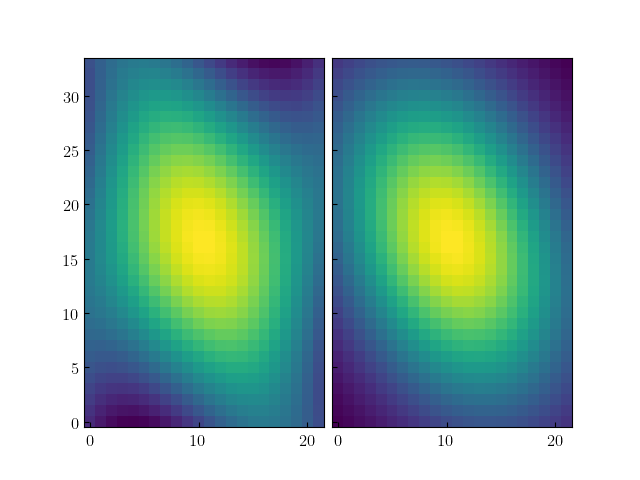

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


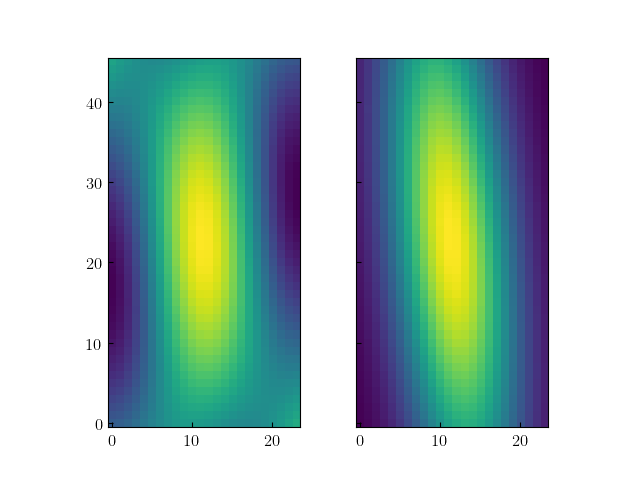

<IPython.core.display.Javascript object>


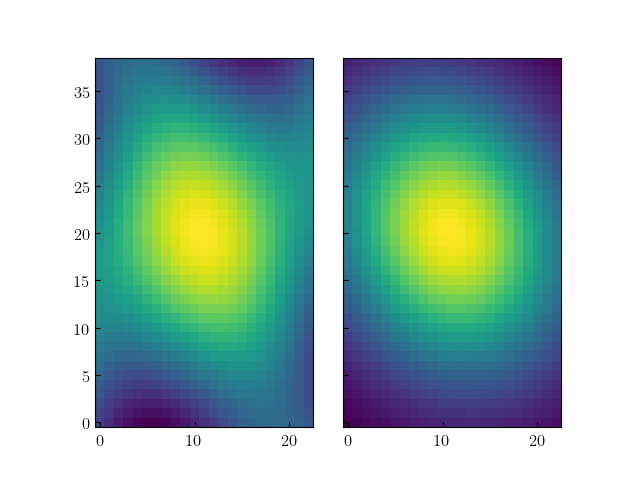

<IPython.core.display.Javascript object>


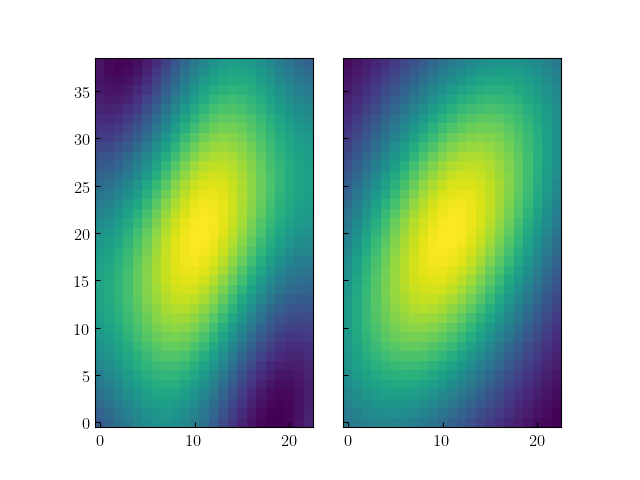

<IPython.core.display.Javascript object>


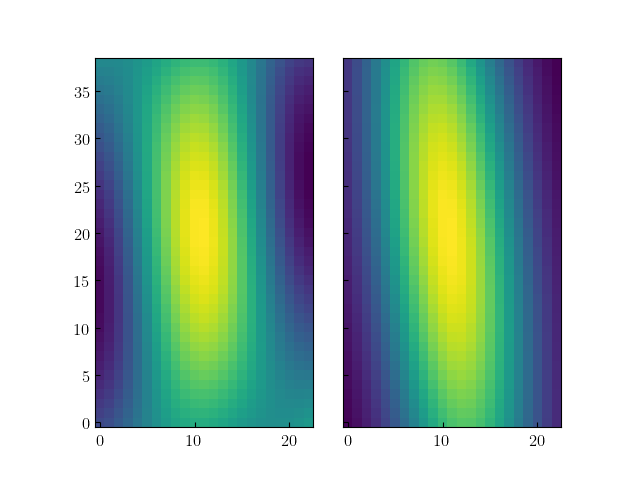

In [79]:
for calkey in ['cal', 'uncal']:
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True)
        axs[0].imshow(scipy_fit_output_2[calkey][fname]['data'], origin='lower')
        axs[1].imshow(scipy_fit_output_2[calkey][fname]['modelfit'], origin='lower')
        fig.subplots_adjust(hspace=0, wspace=0)

# Determine fringe NPC equations

In [80]:
points = {}
coeff_dvect_lines = {}
dvect_range_lines = {}

dl_data = NP.sin(NP.radians(NP.abs(wcs.wcs.cdelt[0])))
dm_data = NP.sin(NP.radians(NP.abs(wcs.wcs.cdelt[1])))

for calkey in ['cal', 'uncal']:
    points[calkey] = []
    coeff_dvect_lines[calkey] = []
    for fnamei,fname in enumerate(imgdata['two-fringes'][calkey]):
        print(fnamei, fname)
        points[calkey] += [NP.asarray([scipy_fit_output_2[calkey][fname]['parameters']['x_center'], scipy_fit_output_2[calkey][fname]['parameters']['y_center']])]
    points[calkey] = NP.asarray(points[calkey])
    coeff_dvect_lines[calkey] = GEOM.generate_line_from_point_and_slope(points[calkey], fringe_slopes_data)
    dvect_range_lines[calkey] = GEOM.generate_parallel_lines_at_distance_from_line(coeff_dvect_lines[calkey][:,:2], coeff_dvect_lines[calkey][:,2], NP.degrees(pos_err)/NP.sqrt(NP.abs(wcs.wcs.cdelt[0]*wcs.wcs.cdelt[1])))
# points2 = NP.asarray(points2)

fringe_NPC_info = {}
for calkey in ['cal', 'uncal']:
    fringe_NPC_info[calkey] = {}
    for fnamei,fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        fringe_NPC_info[calkey][fname] = {}
        fringe_NPC_info[calkey][fname]['equation'] = coeff_dvect_lines[calkey][fnamei]
        xvals = NP.arange(imgdata[imgfilenames['bl-fringes'][calkey][fnamei]].squeeze().shape[1])
        yvals = GEOM.get_ordinate_from_abscissa_on_line(coeff_dvect_lines[calkey][fnamei][:2], coeff_dvect_lines[calkey][fnamei][2], xvals)
        yvals_lim1 = GEOM.get_ordinate_from_abscissa_on_line(coeff_dvect_lines[calkey][fnamei][:2], dvect_range_lines[calkey][fnamei][0], xvals)
        yvals_lim2 = GEOM.get_ordinate_from_abscissa_on_line(coeff_dvect_lines[calkey][fnamei][:2], dvect_range_lines[calkey][fnamei][1], xvals)
        fringe_NPC_info[calkey][fname]['xvals'] = NP.copy(xvals)
        fringe_NPC_info[calkey][fname]['yvals'] = NP.copy(yvals)
        fringe_NPC_info[calkey][fname]['yvals_lim1'] = NP.copy(yvals_lim1)
        fringe_NPC_info[calkey][fname]['yvals_lim2'] = NP.copy(yvals_lim2)
        

# calkey = 'cal'
# points1 = []
# points2 = []
# for fnamei,fname in enumerate(imgfilenames['bl-fringes'][calkey]):
#     fname_next = imgfilenames['bl-fringes'][calkey][(fnamei+1)%3]
#     fname_next2 = imgfilenames['bl-fringes'][calkey][(fnamei+2)%3]
#     fkey_out = '{0}+{1}'.format(fname.split('.fits')[0], fname_next.split('.fits')[0])
#     fkey_out2 = '{0}+{1}'.format(fname_next2.split('.fits')[0], fname.split('.fits')[0])
#     points1 += [NP.asarray([scipy_fit_output_2[fkey_out]['parameters']['x_center'], scipy_fit_output_2[fkey_out]['parameters']['y_center']])]
#     points2 += [NP.asarray([scipy_fit_output_2[fkey_out2]['parameters']['x_center'], scipy_fit_output_2[fkey_out2]['parameters']['y_center']])]
#     print(fkey_out, fkey_out2)
# points1 = NP.asarray(points1)
# points2 = NP.asarray(points2)
# coeff_dvect_lines = GEOM.generate_line_from_two_points(points1, points2)

(0, '0913+0919')
(1, '0919+1319')
(2, '1319+0913')
(0, '0913u+0919u')
(1, '0919u+1319u')
(2, '1319u+0913u')


In [81]:
print(coeff_dvect_lines)
print(fringe_slopes_data)
print(yvals)
print(yvals_lim1)
print(yvals_lim2)

{'uncal': array([[   2.63164997,    1.        ,  254.61485566],
       [  -0.48424184,    1.        ,   37.10095621],
       [  -6.29968882,    1.        , -367.77008464]]), 'cal': array([[   2.63164997,    1.        ,  235.46266499],
       [  -0.48424184,    1.        ,   28.48811448],
       [  -6.29968882,    1.        , -357.04260859]])}
[-2.63165     0.48424184  6.299689  ]
[-367.77008464 -361.47039582 -355.17070701 -348.87101819 -342.57132938
 -336.27164056 -329.97195174 -323.67226293 -317.37257411 -311.0728853
 -304.77319648 -298.47350766 -292.17381885 -285.87413003 -279.57444122
 -273.2747524  -266.97506358 -260.67537477 -254.37568595 -248.07599713
 -241.77630832 -235.4766195  -229.17693069 -222.87724187 -216.57755305
 -210.27786424 -203.97817542 -197.67848661 -191.37879779 -185.07910897
 -178.77942016 -172.47973134 -166.18004253 -159.88035371 -153.58066489
 -147.28097608 -140.98128726 -134.68159845 -128.38190963 -122.08222081
 -115.782532   -109.48284318 -103.18315437  -96.88

# Verify that the fringe NPC equations determined align with the fringes in direction-cosine coordinates

<IPython.core.display.Javascript object>


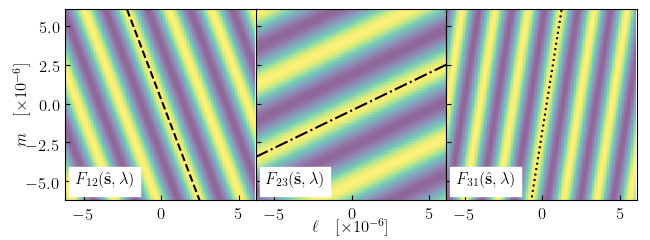

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_cal_fringes_fitted_NPC_dircos.pdf


<IPython.core.display.Javascript object>


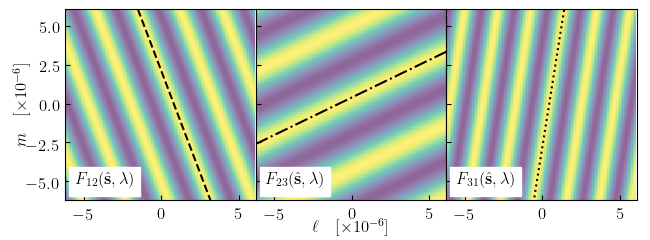

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_uncal_fringes_fitted_NPC_dircos.pdf


In [83]:
fname = '0913.fits'
wcs = WCS(imghdrs[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
lvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS1']) - center[0,0]) * NP.abs(dl_data)
mvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS2']) - center[0,1]) * NP.abs(dm_data)

ls = ['--', '-.', ':']
for calkey in ['cal', 'uncal']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        data = imgdata[fname].squeeze()[:,::-1]
        axs[fnamei].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)

#         axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#         ax.text(center[0,0]-1, center[0,1], 'O', transform=ax.transData, ha='center', va='center', fontsize=10, color='magenta')
#         fname_next = imgfilenames['bl-fringes'][calkey][(fnamei+1)%3]
#         fname_next2 = imgfilenames['bl-fringes'][calkey][(fnamei+2)%3]
        l_xvals = (fringe_NPC_info[calkey][fname]['xvals'] - center[0,0]) * NP.abs(dl_data)
        m_yvals = (fringe_NPC_info[calkey][fname]['yvals'] - center[0,1]) * NP.abs(dm_data)
        axs[fnamei].plot(l_xvals/1e-6, m_yvals/1e-6, color='black', ls=ls[fnamei])
#         ax.plot(fringe_NPC_info[calkey][fname_next]['xvals'], fringe_NPC_info[calkey][fname_next]['yvals'], color='black', ls='-')
#         ax.plot(fringe_NPC_info[calkey][fname_next2]['xvals'], fringe_NPC_info[calkey][fname_next2]['yvals'], color='black', ls='-')
        axs[fnamei].set_xlim(lvect_data.min()/1e-6, lvect_data.max()/1e-6)
        axs[fnamei].set_ylim(mvect_data.min()/1e-6, mvect_data.max()/1e-6)

    axs[0].text(0.05, 0.05, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[0].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[1].text(0.05, 0.05, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[1].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[2].text(0.05, 0.05, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[2].transAxes, fontsize=12, color='black', backgroundcolor='white')

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.1, right=0.98, bottom=0.15, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel(r'$\ell \quad [\times 10^{-6}]$', fontsize=12, weight='medium', labelpad=10)
    big_ax.set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=12, weight='medium', labelpad=25)

    PLT.savefig(figdir+'3C286_individual_{0}_fringes_fitted_NPC_dircos.pdf'.format(calkey), bbox_inches=0)
    print(figdir+'3C286_individual_{0}_fringes_fitted_NPC_dircos.pdf'.format(calkey))


In [ ]:
# fname = '0913.fits'
# wcs = WCS(imghdrs[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
# lvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS1']) - center[0,0]) * NP.abs(dl_data)
# mvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS2']) - center[0,1]) * NP.abs(dm_data)

# ls = ['--', '-.', ':']
# for calkey in ['cal', 'uncal']:
#     fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))
#     for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
#         data = imgdata[fname].squeeze()[:,::-1]
#         axs[fnamei].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)

# #         axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
# #         ax.text(center[0,0]-1, center[0,1], 'O', transform=ax.transData, ha='center', va='center', fontsize=10, color='magenta')
# #         fname_next = imgfilenames['bl-fringes'][calkey][(fnamei+1)%3]
# #         fname_next2 = imgfilenames['bl-fringes'][calkey][(fnamei+2)%3]
#         l_xvals = (fringe_NPC_info[calkey][fname]['xvals'] - center[0,0]) * NP.abs(dl_data)
#         m_yvals = (fringe_NPC_info[calkey][fname]['yvals'] - center[0,1]) * NP.abs(dm_data)
#         axs[fnamei].plot(l_xvals/1e-6, m_yvals/1e-6, color='black', ls=ls[fnamei])
# #         ax.plot(fringe_NPC_info[calkey][fname_next]['xvals'], fringe_NPC_info[calkey][fname_next]['yvals'], color='black', ls='-')
# #         ax.plot(fringe_NPC_info[calkey][fname_next2]['xvals'], fringe_NPC_info[calkey][fname_next2]['yvals'], color='black', ls='-')
#         axs[fnamei].set_xlim(lvect_data.min()/1e-6, lvect_data.max()/1e-6)
#         axs[fnamei].set_ylim(mvect_data.min()/1e-6, mvect_data.max()/1e-6)

#     axs[0].text(0.05, 0.05, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[0].transAxes, fontsize=10, color='black', backgroundcolor='white')
#     axs[1].text(0.05, 0.05, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[1].transAxes, fontsize=10, color='black', backgroundcolor='white')
#     axs[2].text(0.05, 0.05, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[2].transAxes, fontsize=10, color='black', backgroundcolor='white')

#     fig.subplots_adjust(hspace=0, wspace=0)
#     fig.subplots_adjust(left=0.1, right=0.98, bottom=0.15, top=0.98)

#     big_ax = fig.add_subplot(111)
#     big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
#     # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
#     big_ax.spines['right'].set_visible(False)
#     big_ax.spines['top'].set_visible(False)
#     big_ax.spines['left'].set_visible(False)
#     big_ax.spines['bottom'].set_visible(False)
#     big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#     big_ax.set_xticks([])
#     big_ax.set_yticks([])
#     big_ax.set_xlabel(r'$l \quad [\times 10^{-6}]$', fontsize=10, weight='medium', labelpad=10)
#     big_ax.set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=10, weight='medium', labelpad=25)

#     PLT.savefig(figdir+'3C286_individual_{0}_fringes_fitted_NPC_dircos.pdf'.format(calkey), bbox_inches=0)
#     print(figdir+'3C286_individual_{0}_fringes_fitted_NPC_dircos.pdf'.format(calkey))


# Verify that the fringe NPC equations determined align with the fringes in RA-Dec coordinates

<IPython.core.display.Javascript object>


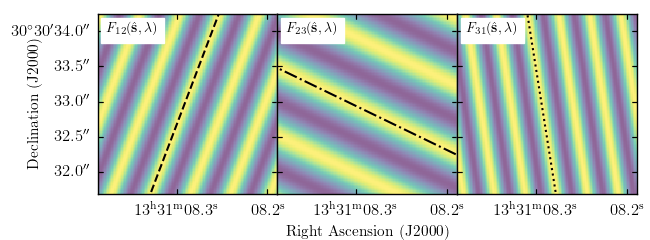

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_cal_fringes_fitted_NPC.pdf


<IPython.core.display.Javascript object>


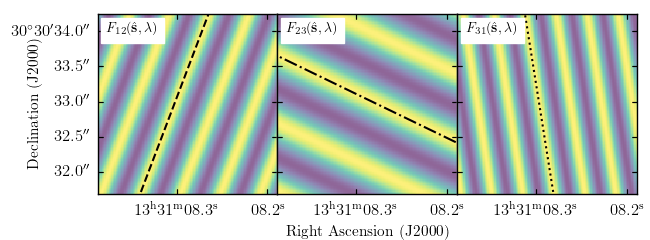

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_uncal_fringes_fitted_NPC.pdf


In [86]:
fname = '0913.fits'
wcs = WCS(imghdrs[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

ls = ['--', '-.', ':']
for calkey in ['cal', 'uncal']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        data = imgdata[fname].squeeze()
#         axs[fnamei].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)

        axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
        xvals = fringe_NPC_info[calkey][fname]['xvals']
        yvals = fringe_NPC_info[calkey][fname]['yvals']
        axs[fnamei].plot(xvals[::-1], yvals, color='black', ls=ls[fnamei])
        axs[fnamei].set_xlim(0, data.shape[1])
        axs[fnamei].set_ylim(0, data.shape[0])

        lon = axs[fnamei].coords[0]
        lat = axs[fnamei].coords[1]
        lon.set_major_formatter('hh:mm:ss.s')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
        if fnamei > 0:
            lat.set_ticklabel_visible(False)

    axs[0].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=10, color='black', backgroundcolor='white')
    axs[1].text(0.05, 0.95, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=10, color='black', backgroundcolor='white')
    axs[2].text(0.05, 0.95, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=10, color='black', backgroundcolor='white')

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=15)
    big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=40)

    PLT.savefig(figdir+'3C286_individual_{0}_fringes_fitted_NPC.pdf'.format(calkey), bbox_inches=0)
    print(figdir+'3C286_individual_{0}_fringes_fitted_NPC.pdf'.format(calkey))

In [ ]:
# fname = '0913.fits'
# wcs = WCS(imghdrs[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

# ls = ['--', '-.', ':']
# for calkey in ['cal', 'uncal']:
#     fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(6.5,2.4))
#     for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
#         data = imgdata[fname].squeeze()
# #         axs[fnamei].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)

#         axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#         xvals = fringe_NPC_info[calkey][fname]['xvals']
#         yvals = fringe_NPC_info[calkey][fname]['yvals']
#         axs[fnamei].plot(xvals[::-1], yvals, color='black', ls=ls[fnamei])
#         axs[fnamei].set_xlim(0, data.shape[1])
#         axs[fnamei].set_ylim(0, data.shape[0])

#         lon = axs[fnamei].coords[0]
#         lat = axs[fnamei].coords[1]
#         lon.set_major_formatter('hh:mm:ss.s')
#         lat.set_major_formatter('dd:mm:ss.s')
#         lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
#         lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
#         if fnamei > 0:
#             lat.set_ticklabel_visible(False)

#     axs[0].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=10, color='black', backgroundcolor='white')
#     axs[1].text(0.05, 0.95, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=10, color='black', backgroundcolor='white')
#     axs[2].text(0.05, 0.95, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=10, color='black', backgroundcolor='white')

#     fig.subplots_adjust(hspace=0, wspace=0)
#     fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

#     big_ax = fig.add_subplot(111)
#     big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
#     # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
#     big_ax.spines['right'].set_visible(False)
#     big_ax.spines['top'].set_visible(False)
#     big_ax.spines['left'].set_visible(False)
#     big_ax.spines['bottom'].set_visible(False)
#     big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#     big_ax.set_xticks([])
#     big_ax.set_yticks([])
#     big_ax.set_xlabel('Right Ascension (J2000)', fontsize=10, weight='medium', labelpad=15)
#     big_ax.set_ylabel('Declination (J2000)', fontsize=10, weight='medium', labelpad=40)

#     PLT.savefig(figdir+'3C286_individual_{0}_fringes_fitted_NPC.pdf'.format(calkey), bbox_inches=0)
#     print(figdir+'3C286_individual_{0}_fringes_fitted_NPC.pdf'.format(calkey))

<IPython.core.display.Javascript object>


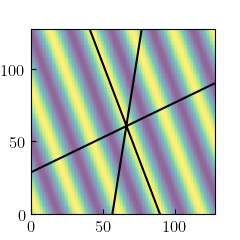

<IPython.core.display.Javascript object>


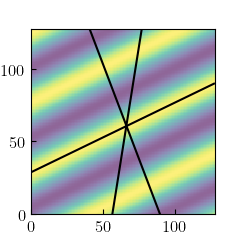

<IPython.core.display.Javascript object>


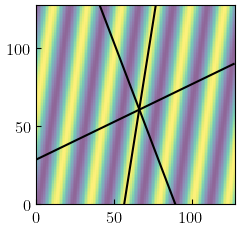

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_cal_fringes_fitted_NPC.pdf


<IPython.core.display.Javascript object>


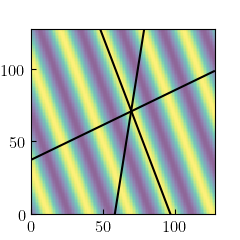

<IPython.core.display.Javascript object>


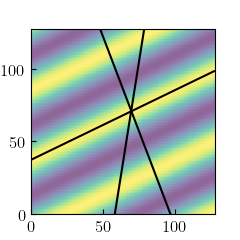

<IPython.core.display.Javascript object>


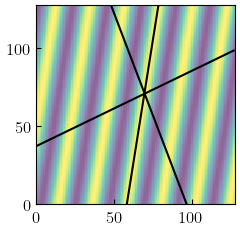

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_uncal_fringes_fitted_NPC.pdf


In [87]:
fname = '0913.fits'
wcs = WCS(imghdrs[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

ls = ['--', '-.', ':']
for calkey in ['cal', 'uncal']:
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        fig, ax = PLT.subplots(nrows=1, ncols=1, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(2.4,2.4))
        data = imgdata[fname].squeeze()[:,::-1]
        center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
        ax.imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#         ax.text(center[0,0]-1, center[0,1], 'O', transform=ax.transData, ha='center', va='center', fontsize=10, color='magenta')
        ax.set_xlim(0, data.shape[1])
        ax.set_ylim(0, data.shape[0])
        fname_next = imgfilenames['bl-fringes'][calkey][(fnamei+1)%3]
        fname_next2 = imgfilenames['bl-fringes'][calkey][(fnamei+2)%3]
        ax.plot(fringe_NPC_info[calkey][fname]['xvals'], fringe_NPC_info[calkey][fname]['yvals'], color='black', ls='-')
        ax.plot(fringe_NPC_info[calkey][fname_next]['xvals'], fringe_NPC_info[calkey][fname_next]['yvals'], color='black', ls='-')
        ax.plot(fringe_NPC_info[calkey][fname_next2]['xvals'], fringe_NPC_info[calkey][fname_next2]['yvals'], color='black', ls='-')
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    # big_ax.set_xlabel('Right Ascension (J2000)', fontsize=10, weight='medium', labelpad=10)
    # big_ax.set_ylabel('Declination (J2000)', fontsize=10, weight='medium', labelpad=40)

    # PLT.savefig(figdir+'3C286_individual_cal_fringes.pdf', bbox_inches=0)
    print(figdir+'3C286_individual_{0}_fringes_fitted_NPC.pdf'.format(calkey))


# Plot three fringe images calibrated and uncalibrated with fitted NPC in direction-cosine coordinates 

<IPython.core.display.Javascript object>


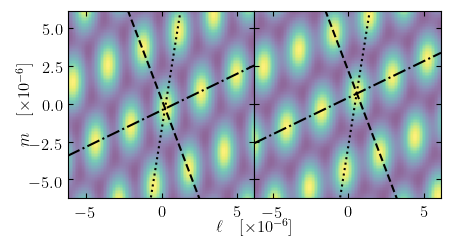

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_dircos.pdf


<IPython.core.display.Javascript object>


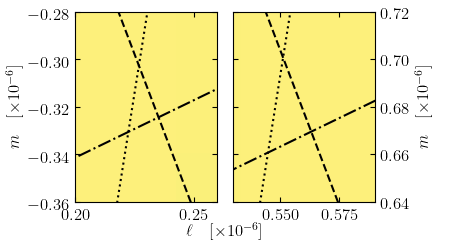

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_zoomed_dircos.pdf
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_zoomed_dircos.pdf


In [90]:
fname = '0913.fits'
wcs = WCS(imghdrs[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
lvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS1']) - center[0,0]) * NP.abs(dl_data)
mvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS2']) - center[0,1]) * NP.abs(dm_data)

ls = ['--', '-.', ':']

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(4.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()[:,::-1]
    axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        l_xvals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
        m_yvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)
        axs[calind].plot(l_xvals/1e-6, m_yvals/1e-6, color='black', ls=ls[fnamej])
    axs[calind].set_xlim(lvect_data.min()/1e-6, lvect_data.max()/1e-6)
    axs[calind].set_ylim(mvect_data.min()/1e-6, mvect_data.max()/1e-6)
    axs[calind].tick_params(bottom=True, top=True, left=True, right=True)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel(r'$\ell \quad [\times 10^{-6}]$', fontsize=12, weight='medium', labelpad=10)
big_ax.set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=12, weight='medium', labelpad=25)

PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC_dircos.pdf', bbox_inches=0)
print(figdir+'3C286_all_fringes_fitted_NPC_dircos.pdf')

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=False, sharey=False, subplot_kw={'aspect': 'equal'}, figsize=(4.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()[:,::-1]
    axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        l_xvals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
        m_yvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)
        axs[calind].plot(l_xvals/1e-6, m_yvals/1e-6, color='black', ls=ls[fnamej])
    if calkey == 'cal': 
        axs[calind].set_xlim(0.2, 0.26)
        axs[calind].set_ylim(-0.36, -0.28)
        axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=12, weight='medium')
    else:
        axs[calind].set_xlim(0.53, 0.59)
        axs[calind].set_ylim(0.64, 0.72)
        axs[calind].yaxis.tick_right()
        axs[calind].yaxis.set_label_position('right')
        axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True)
        axs[calind].set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=12, weight='medium')
        
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.16, top=0.95)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel(r'$\ell \quad [\times 10^{-6}]$', fontsize=12, weight='medium', labelpad=15)

    PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC_zoomed_dircos.pdf', bbox_inches=0)
    print(figdir+'3C286_all_fringes_fitted_NPC_zoomed_dircos.pdf')

In [ ]:
# fname = '0913.fits'
# wcs = WCS(imghdrs[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
# lvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS1']) - center[0,0]) * NP.abs(dl_data)
# mvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS2']) - center[0,1]) * NP.abs(dm_data)

# ls = ['--', '-.', ':']

# fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(4.5,2.4))
# for calind,calkey in enumerate(['cal', 'uncal']):
#     fname = imgfilenames['triad-fringes'][calkey]
#     data = imgdata[fname].squeeze()[:,::-1]
#     axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
#     for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
#         l_xvals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
#         m_yvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)
#         axs[calind].plot(l_xvals/1e-6, m_yvals/1e-6, color='black', ls=ls[fnamej])
#     axs[calind].set_xlim(lvect_data.min()/1e-6, lvect_data.max()/1e-6)
#     axs[calind].set_ylim(mvect_data.min()/1e-6, mvect_data.max()/1e-6)
#     axs[calind].tick_params(bottom=True, top=True, left=True, right=True)

# fig.subplots_adjust(hspace=0, wspace=0)
# fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

# big_ax = fig.add_subplot(111)
# big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
# big_ax.spines['right'].set_visible(False)
# big_ax.spines['top'].set_visible(False)
# big_ax.spines['left'].set_visible(False)
# big_ax.spines['bottom'].set_visible(False)
# big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# big_ax.set_xticks([])
# big_ax.set_yticks([])
# big_ax.set_xlabel(r'$l \quad [\times 10^{-6}]$', fontsize=10, weight='medium', labelpad=10)
# big_ax.set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=10, weight='medium', labelpad=25)

# PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC_dircos.pdf', bbox_inches=0)
# print(figdir+'3C286_all_fringes_fitted_NPC_dircos.pdf')

# fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=False, sharey=False, subplot_kw={'aspect': 'equal'}, figsize=(4.5,2.4))
# for calind,calkey in enumerate(['cal', 'uncal']):
#     fname = imgfilenames['triad-fringes'][calkey]
#     data = imgdata[fname].squeeze()[:,::-1]
#     axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
#     for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
#         l_xvals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
#         m_yvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)
#         axs[calind].plot(l_xvals/1e-6, m_yvals/1e-6, color='black', ls=ls[fnamej])
#     if calkey == 'cal': 
#         axs[calind].set_xlim(0.2, 0.26)
#         axs[calind].set_ylim(-0.36, -0.28)
#         axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
#         axs[calind].set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=10, weight='medium')
#     else:
#         axs[calind].set_xlim(0.53, 0.59)
#         axs[calind].set_ylim(0.64, 0.72)
#         axs[calind].yaxis.tick_right()
#         axs[calind].yaxis.set_label_position('right')
#         axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
#         axs[calind].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True)
#         axs[calind].set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=10, weight='medium')
        
#     fig.subplots_adjust(hspace=0, wspace=0)
#     fig.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.95)

#     big_ax = fig.add_subplot(111)
#     big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
#     # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
#     big_ax.spines['right'].set_visible(False)
#     big_ax.spines['top'].set_visible(False)
#     big_ax.spines['left'].set_visible(False)
#     big_ax.spines['bottom'].set_visible(False)
#     big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#     big_ax.set_xticks([])
#     big_ax.set_yticks([])
#     big_ax.set_xlabel(r'$l \quad [\times 10^{-6}]$', fontsize=10, weight='medium', labelpad=15)

#     PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC_zoomed_dircos.pdf', bbox_inches=0)
#     print(figdir+'3C286_all_fringes_fitted_NPC_zoomed_dircos.pdf')

# Plot three fringe images calibrated and uncalibrated with fitted NPC in RA-Dec coordinates 

<IPython.core.display.Javascript object>


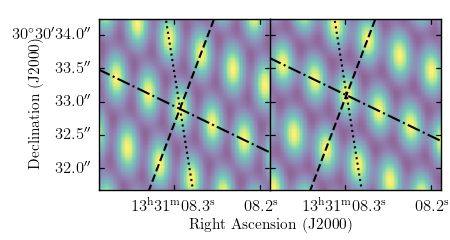

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC.pdf


<IPython.core.display.Javascript object>


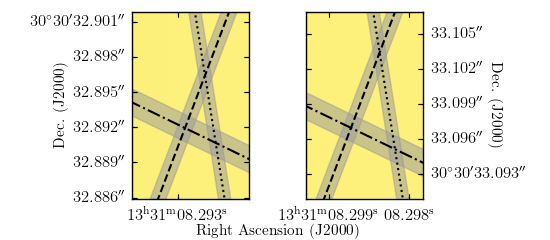

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_zoomed.pdf
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_zoomed.pdf


In [99]:
fname = '0913.fits'
wcs = WCS(imghdrs[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

ls = ['--', '-.', ':']

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(4.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#     axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        xvals = fringe_NPC_info[calkey][fn]['xvals']
        yvals = fringe_NPC_info[calkey][fn]['yvals']
        axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej])
        axs[calind].set_xlim(0, data.shape[1])
        axs[calind].set_ylim(0, data.shape[0])
        lon = axs[calind].coords[0]
        lat = axs[calind].coords[1]
        lon.set_major_formatter('hh:mm:ss.s')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
        if calind > 0:
            lat.set_ticklabel_visible(False)
    axs[calind].set_xlim(0, data.shape[1])
    axs[calind].set_ylim(0, data.shape[0])

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.22, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=10)
big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=40)

PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC.pdf', bbox_inches=0)
print(figdir+'3C286_all_fringes_fitted_NPC.pdf')

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=False, sharey=False, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(5.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#     axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        xvals = fringe_NPC_info[calkey][fn]['xvals']
        yvals = fringe_NPC_info[calkey][fn]['yvals']
        yvals_lim1 = fringe_NPC_info[calkey][fn]['yvals_lim1']
        yvals_lim2 = fringe_NPC_info[calkey][fn]['yvals_lim2']
        axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej])
        axs[calind].fill_between(xvals[::-1], yvals_lim1, yvals_lim2, color='0.6', alpha=0.5)
        lon = axs[calind].coords[0]
        lat = axs[calind].coords[1]
        lon.set_major_formatter('hh:mm:ss.sss')
        lat.set_major_formatter('dd:mm:ss.sss')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))
        axs[calind].set_aspect('equal')

    if calind == 0: 
        axs[calind].set_xlim(60.35, 60.85)
        axs[calind].set_ylim(60.35, 61.15)
        lon.set_ticks(number=2)
        lat.set_ticks(number=4)
        lat.set_ticklabel_position('l')
        lat.set_axislabel_position('l')
        lon.set_ticks(spacing=0.008*U.arcsec)
        lat.set_ticks(spacing=0.003*U.arcsec)
        lon.set_ticklabel(exclude_overlapping=True)
        lat.set_ticklabel(exclude_overlapping=True)
        axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].set_ylabel('Dec. (J2000)', fontsize=11, weight='medium', labelpad=-2)
        axs[calind].yaxis.set_label_position('left')
    else:
        axs[calind].set_xlim(57, 57.5)
        axs[calind].set_ylim(70.6, 71.4)
        lat.set_ticklabel_position('r')
        lat.set_axislabel_position('r')
        lon.set_ticks(spacing=0.008*U.arcsec)
        lat.set_ticks(spacing=0.003*U.arcsec)
        lon.set_ticklabel(exclude_overlapping=True)
        lat.set_ticklabel(exclude_overlapping=True)
        axs[calind].set_ylabel('Dec. (J2000)', fontsize=11, weight='medium', labelpad=-2)
        
    fig.subplots_adjust(hspace=0, wspace=0.15)
    fig.subplots_adjust(left=0.21, right=0.8, bottom=0.17, top=0.95)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=18)
#     big_ax.set_ylabel('Declination (J2000)', fontsize=10, weight='medium', labelpad=35)
#     big_ax.set_xlabel(r'$l \quad [\times 10^{-6}]$', fontsize=10, weight='medium', labelpad=15)

    PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC_zoomed.pdf', bbox_inches=0)
    print(figdir+'3C286_all_fringes_fitted_NPC_zoomed.pdf')

In [ ]:
# fname = '0913.fits'
# wcs = WCS(imghdrs[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

# ls = ['--', '-.', ':']

# fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(4.5,2.4))
# for calind,calkey in enumerate(['cal', 'uncal']):
#     fname = imgfilenames['triad-fringes'][calkey]
#     data = imgdata[fname].squeeze()
#     axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
# #     axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
#     for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
#         xvals = fringe_NPC_info[calkey][fn]['xvals']
#         yvals = fringe_NPC_info[calkey][fn]['yvals']
#         axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej])
#         axs[calind].set_xlim(0, data.shape[1])
#         axs[calind].set_ylim(0, data.shape[0])
#         lon = axs[calind].coords[0]
#         lat = axs[calind].coords[1]
#         lon.set_major_formatter('hh:mm:ss.s')
#         lat.set_major_formatter('dd:mm:ss.s')
#         lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
#         lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
#         if calind > 0:
#             lat.set_ticklabel_visible(False)
#     axs[calind].set_xlim(0, data.shape[1])
#     axs[calind].set_ylim(0, data.shape[0])

# fig.subplots_adjust(hspace=0, wspace=0)
# fig.subplots_adjust(left=0.22, right=0.98, bottom=0.15, top=0.98)

# big_ax = fig.add_subplot(111)
# big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
# big_ax.spines['right'].set_visible(False)
# big_ax.spines['top'].set_visible(False)
# big_ax.spines['left'].set_visible(False)
# big_ax.spines['bottom'].set_visible(False)
# big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# big_ax.set_xticks([])
# big_ax.set_yticks([])
# big_ax.set_xlabel('Right Ascension (J2000)', fontsize=10, weight='medium', labelpad=15)
# big_ax.set_ylabel('Declination (J2000)', fontsize=10, weight='medium', labelpad=40)

# PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC.pdf', bbox_inches=0)
# print(figdir+'3C286_all_fringes_fitted_NPC.pdf')

# fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=False, sharey=False, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(5.5,2.4))
# for calind,calkey in enumerate(['cal', 'uncal']):
#     fname = imgfilenames['triad-fringes'][calkey]
#     data = imgdata[fname].squeeze()
#     axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
# #     axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
#     for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
#         xvals = fringe_NPC_info[calkey][fn]['xvals']
#         yvals = fringe_NPC_info[calkey][fn]['yvals']
#         yvals_lim1 = fringe_NPC_info[calkey][fn]['yvals_lim1']
#         yvals_lim2 = fringe_NPC_info[calkey][fn]['yvals_lim2']
#         axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej])
#         axs[calind].fill_between(xvals[::-1], yvals_lim1, yvals_lim2, color='0.6', alpha=0.5)
#         lon = axs[calind].coords[0]
#         lat = axs[calind].coords[1]
#         lon.set_major_formatter('hh:mm:ss.sss')
#         lat.set_major_formatter('dd:mm:ss.sss')
#         lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
#         lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))
#         axs[calind].set_aspect('equal')

#     if calind == 0: 
#         axs[calind].set_xlim(60.35, 60.85)
#         axs[calind].set_ylim(60.35, 61.15)
#         lon.set_ticks(number=2)
#         lat.set_ticks(number=4)
#         lat.set_ticklabel_position('l')
#         lat.set_axislabel_position('l')
#         lon.set_ticks(spacing=0.008*U.arcsec)
#         lat.set_ticks(spacing=0.003*U.arcsec)
#         lon.set_ticklabel(exclude_overlapping=True)
#         lat.set_ticklabel(exclude_overlapping=True)
#         axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
#         axs[calind].set_ylabel('Dec. (J2000)', fontsize=10, weight='medium', labelpad=-2.5)
#         axs[calind].yaxis.set_label_position('left')
#     else:
#         axs[calind].set_xlim(57, 57.5)
#         axs[calind].set_ylim(70.6, 71.4)
#         lat.set_ticklabel_position('r')
#         lat.set_axislabel_position('r')
#         lon.set_ticks(spacing=0.008*U.arcsec)
#         lat.set_ticks(spacing=0.003*U.arcsec)
#         lon.set_ticklabel(exclude_overlapping=True)
#         lat.set_ticklabel(exclude_overlapping=True)
#         axs[calind].set_ylabel('Dec. (J2000)', fontsize=10, weight='medium', labelpad=-2.75)
        
#     fig.subplots_adjust(hspace=0, wspace=0.15)
#     fig.subplots_adjust(left=0.23, right=0.78, bottom=0.15, top=0.95)

#     big_ax = fig.add_subplot(111)
#     big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
#     # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
#     big_ax.spines['right'].set_visible(False)
#     big_ax.spines['top'].set_visible(False)
#     big_ax.spines['left'].set_visible(False)
#     big_ax.spines['bottom'].set_visible(False)
#     big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#     big_ax.set_xticks([])
#     big_ax.set_yticks([])
#     big_ax.set_xlabel('Right Ascension (J2000)', fontsize=10, weight='medium', labelpad=15)
# #     big_ax.set_ylabel('Declination (J2000)', fontsize=10, weight='medium', labelpad=35)
# #     big_ax.set_xlabel(r'$l \quad [\times 10^{-6}]$', fontsize=10, weight='medium', labelpad=15)

#     PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC_zoomed.pdf', bbox_inches=0)
#     print(figdir+'3C286_all_fringes_fitted_NPC_zoomed.pdf')

In [100]:
print(imgfilenames['bl-fringes'][calkey])

['0913u.fits', '0919u.fits', '1319u.fits']


In [101]:
perp_distances = {}
phase_offsets = {}
phase_uncertainties = {}
for calkey in ['cal', 'uncal']:
    perp_distances[calkey] = {}
    phase_offsets[calkey] = {}
    phase_uncertainties[calkey] = {}
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        perp_distances[calkey][fname] = (NP.dot(coeff_dvect_lines[calkey][fnamei,:2], points[calkey][(fnamei+1)%3,:]) - coeff_dvect_lines[calkey][fnamei,2]) / NP.sqrt(NP.sum(coeff_dvect_lines[calkey][fnamei,:2]**2)) 
        phase_offsets[calkey][fname] = NP.degrees(2*NP.pi) * perp_distances[calkey][fname] * NP.sqrt(NP.sum(uvw_data[fnamei,:2]**2)) / wl0.to('m').value * dm_data
        for fnamej, fn in enumerate(imgdata['two-fringes'][calkey]):
            if fname not in fn:
                phase_uncertainties[calkey][fname] = NP.degrees(2*NP.pi) * NP.sqrt(NP.diag(scipy_fit_output_2[calkey][fn]['covariance'])[1:3]) * NP.sqrt(NP.sum(uvw_data[fnamei,:2]**2)) / wl0.to('m').value * dm_data
    print('Perpendicular offsets:    ', perp_distances[calkey])
    print('Phase offsets:    ', phase_offsets[calkey])
    print('Phase uncertainties:    ', phase_uncertainties[calkey])
    

('Perpendicular offsets:    ', {'0913.fits': -0.1189183755201114, '0919.fits': 0.21401585372217097, '1319.fits': -0.1028309314980128})
('Phase offsets:    ', {'0913.fits': -1.623803683800333, '0919.fits': 1.7713005343709491, '1319.fits': -1.7045706000378853})
('Phase uncertainties:    ', {'0913.fits': array([0.67675017, 3.91875368]), '0919.fits': array([0.41019478, 2.37525215]), '1319.fits': array([0.82155197, 4.75723533])})
('Perpendicular offsets:    ', {'0919u.fits': 0.2082390418941301, '1319u.fits': -0.12175979090834904, '0913u.fits': -0.14542330158886005})
('Phase offsets:    ', {'0919u.fits': 1.7234887965954255, '1319u.fits': -2.018343671749612, '0913u.fits': -1.9857224907218993})
('Phase uncertainties:    ', {'0919u.fits': array([0.33469774, 2.28913751]), '1319u.fits': array([0.67034395, 4.58476202]), '0913u.fits': array([0.55219316, 3.77667948])})


In [102]:
for calkey in imgfilenames['bl-fringes']:
    imgdata['two-fringes'][calkey] = {}
    for fnamei,fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        fname_next = imgfilenames['bl-fringes'][calkey][(fnamei+1)%3]
        fkey_out = '{0}+{1}'.format(fname.split('.fits')[0], fname_next.split('.fits')[0])
        print('{0} + {1} --> {2}'.format(fname, fname_next, fkey_out))
        imgdata['two-fringes'][calkey][fkey_out] = imgdata[fname] + imgdata[fname_next]

0913u.fits + 0919u.fits --> 0913u+0919u
0919u.fits + 1319u.fits --> 0919u+1319u
1319u.fits + 0913u.fits --> 1319u+0913u
0913.fits + 0919.fits --> 0913+0919
0919.fits + 1319.fits --> 0919+1319
1319.fits + 0913.fits --> 1319+0913


In [103]:
xy_blc = NP.asarray([[56, 44], [55, 38], [55, 38]])
xy_trc = NP.asarray([[77, 77], [78, 83], [78, 83]])
xy_center = NP.asarray([64.0, 64.0])
xgrid, ygrid = NP.meshgrid(NP.arange(xy_blc[0,0], xy_trc[0,0]+1), NP.arange(xy_blc[0,1], xy_trc[0,1]+1))
data_full = imgdata['two-fringes']['cal']['0913+0919'].squeeze()[:,::-1] 
data_subset = data_full[xy_blc[0,1]:xy_trc[0,1]+1, xy_blc[0,0]:xy_trc[0,0]+1]
print(data_subset.shape)
g2d_model = models.Gaussian2D(x_mean=66.5, y_mean=60.5, x_stddev=3.0, y_stddev=6.0, theta=NP.pi/2)
fitter = fitting.LevMarLSQFitter()
g2p = fitter(g2d_model, xgrid, ygrid, data_subset)
print(g2p.x_mean, g2p.y_mean, g2p.x_stddev, g2p.y_stddev, g2p.theta)
model_data = g2p(xgrid, ygrid)
print(model_data.shape)
print(g2p.param_sets)
print(g2p.parameters)

(34, 22)
(Parameter('x_mean', value=66.3998112744), Parameter('y_mean', value=60.6899053553), Parameter('x_stddev', value=4.55064231071, bounds=(1.1754943508222875e-38, None)), Parameter('y_stddev', value=7.43479850599, bounds=(1.1754943508222875e-38, None)), Parameter('theta', value=0.361612909592))
(34, 22)
[[ 9.98960471]
 [66.39981127]
 [60.68990536]
 [ 4.55064231]
 [ 7.43479851]
 [ 0.36161291]]
[ 9.98960471 66.39981127 60.68990536  4.55064231  7.43479851  0.36161291]


In [104]:
xvals = fringe_NPC_info[calkey][fname]['xvals']
yvals = fringe_NPC_info[calkey][fname]['yvals']
coords = SkyCoord.from_pixel(xvals, yvals, wcs, origin=0, mode='all')
print(xvals)
print(yvals)
print(coords)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
[-357.04260859 -350.74291977 -344.44323095 -338.14354214 -331.84385332
 -325.5441645  -319.24447569 -312.94478687 -306.64509806 -300.34540924
 -294.04572042 -287.74603161 -281.44634279 -275.14665398 -268.84696516
 -262.54727634 -256.24758753 -249.94789871 -243.6482099  -237.34852108
 -231.04883226 -224.74914345 -218.44945463 -212.14976582 -205.850077
 -199.55038818 -193.25069937 -186.95101055 -180.65132174 -174.35163292
 -168.0519441  -161.75225529 -155.45256647 -149.1528776

In [105]:
cof = NP.asarray([[1.0, 0.0], [0.0, 1.0], [-0.5, 0.5]])
dv = NP.asarray([2.0, 3.0, 1.0])
dist = NP.asarray([1.0, 2.0, 1.0])
dvpm = GEOM.generate_parallel_lines_at_distance_from_line(cof, dv, dist)
print(dvpm)
print(dvpm[2] * NP.sqrt(2.0))

[[1.         3.        ]
 [1.         5.        ]
 [0.29289322 1.70710678]]
[0.41421356 2.41421356]


In [106]:
print(NP.sqrt(NP.sum(uvw_data[:,:2]**2, axis=1)))
print(wl0.to('m').value)
print(NP.sqrt(NP.sum(uvw_data[:,:2]**2, axis=1)) / wl0.to('m').value)

[12391.4795  7510.778  15042.84  ]
0.0316771405325
[391180.47 237104.03 474879.97]
